In [1]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
labels_df = pd.read_csv('labels.csv')

In [3]:
data_dir = '/content/drive/MyDrive/traffic_Data/DATA'
images = []
labels = []

In [4]:
for class_folder in os.listdir(data_dir):
    class_id = int(class_folder)
    class_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

        class_name = labels_df.loc[labels_df['ClassId'] == class_id, 'Name'].iloc[0]
        labels.append(class_name)

In [5]:
resized_images = []


In [6]:
resized_images = []
for img in images:
    resized_img = cv2.resize(img, (224, 224))
    resized_images.append(resized_img)

In [7]:
images = np.array(resized_images)
labels = np.array(labels)

In [8]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
max_count = np.max(label_counts)

In [9]:
oversampled_images = []
oversampled_labels = []


In [12]:
for label, count in zip(unique_labels, label_counts):
    label_images = images[oversampled_labels == label]
    num_to_duplicate = max_count - count
    if num_to_duplicate > 0:

        oversampled_images.extend(label_images)
        oversampled_labels.extend([label] * num_to_duplicate)

In [11]:
print(images.shape , labels.shape)

(4170, 224, 224, 3) (4170,)


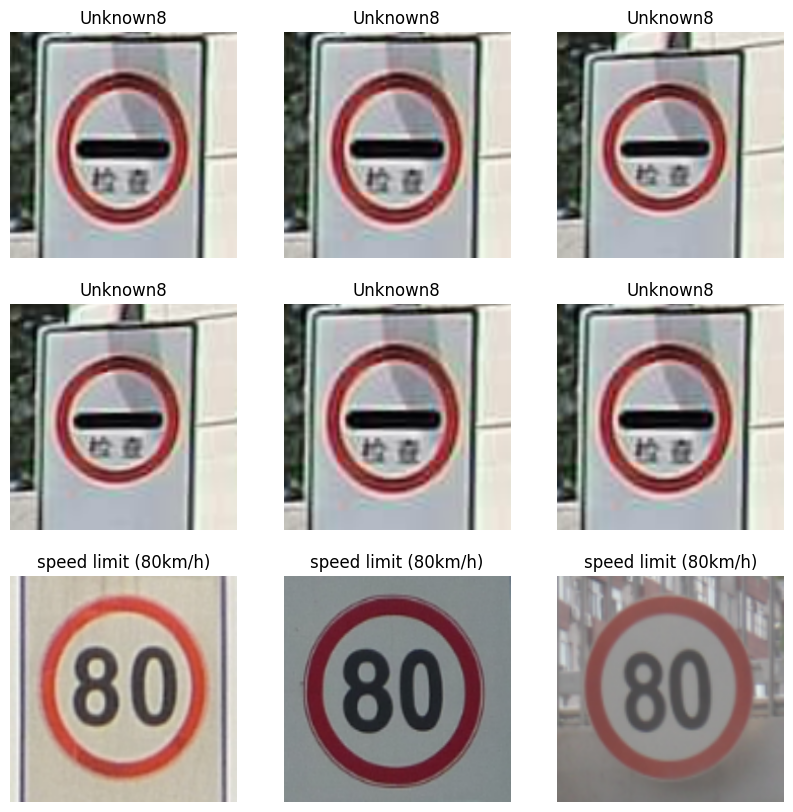

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [14]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 4s 0us/step


In [15]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(58, activation='softmax')(x)

In [16]:
resnet_model = Model(inputs=base_model.input, outputs=output)

In [17]:
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [19]:

checkpoint_filepath = 'model_weights.h5'


checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [22]:
X_resized = np.array(resized_images)

In [23]:
X_train_resized, X_test_resized, y_train, y_test = train_test_split(X_resized, labels, test_size=0.2, random_state=42)

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
label_encoder = LabelEncoder()


y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [27]:
history = resnet_model.fit(X_train_resized, y_train_encoded,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_resized, y_test_encoded),
                    callbacks=[checkpoint_callback])


test_loss, test_acc = resnet_model.evaluate(X_test_resized, y_test_encoded)
print("Test Accuracy:", test_acc)

Epoch 1/10
105/105 [==============================] - 2741s 26s/step - loss: 0.9505 - accuracy: 0.7728 - val_loss: 45.0711 - val_accuracy: 0.1427
Epoch 2/10
105/105 [==============================] - 2630s 25s/step - loss: 0.2520 - accuracy: 0.9356 - val_loss: 0.6765 - val_accuracy: 0.8237
Epoch 3/10
105/105 [==============================] - 2681s 26s/step - loss: 0.0714 - accuracy: 0.9802 - val_loss: 0.1776 - val_accuracy: 0.9568
Epoch 4/10
105/105 [==============================] - 2707s 26s/step - loss: 0.0237 - accuracy: 0.9946 - val_loss: 0.0426 - val_accuracy: 0.9904
Epoch 5/10
105/105 [==============================] - 2672s 25s/step - loss: 0.0374 - accuracy: 0.9892 - val_loss: 2.1192 - val_accuracy: 0.7158
Epoch 6/10
105/105 [==============================] - 2668s 25s/step - loss: 0.2671 - accuracy: 0.9418 - val_loss: 10.8727 - val_accuracy: 0.3369
Epoch 7/10
105/105 [==============================] - 2616s 25s/step - loss: 0.0637 - accuracy: 0.9832 - val_loss: 0.0421 - val_

1/1 [==============================] - 3s 3s/step
input_1 (1, 224, 224, 3)


<Figure size 640x480 with 0 Axes>

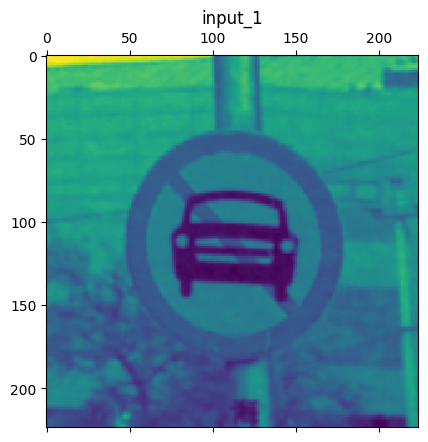

conv1_pad (1, 230, 230, 3)


<Figure size 640x480 with 0 Axes>

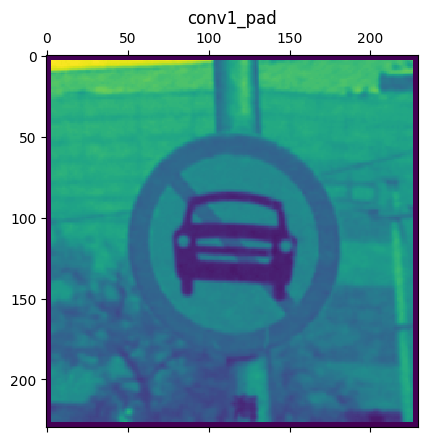

conv1_conv (1, 112, 112, 64)


<Figure size 640x480 with 0 Axes>

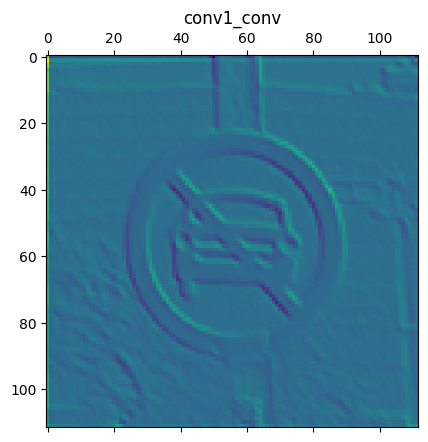

conv1_bn (1, 112, 112, 64)


<Figure size 640x480 with 0 Axes>

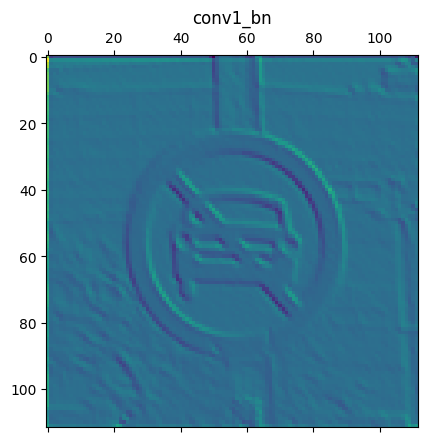

conv1_relu (1, 112, 112, 64)


<Figure size 640x480 with 0 Axes>

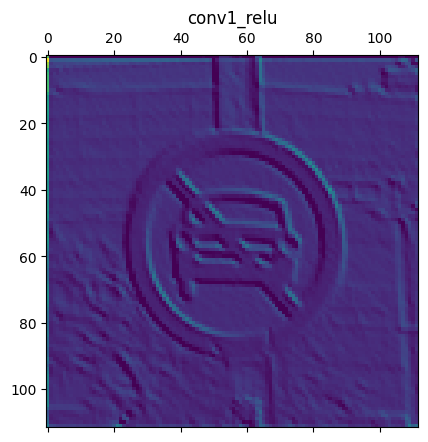

pool1_pad (1, 114, 114, 64)


<Figure size 640x480 with 0 Axes>

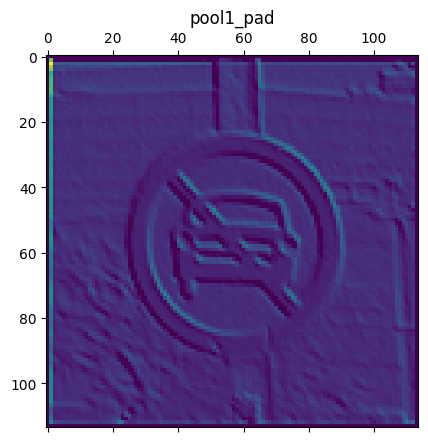

pool1_pool (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

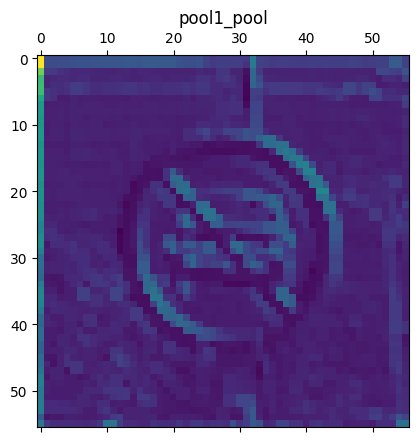

conv2_block1_1_conv (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

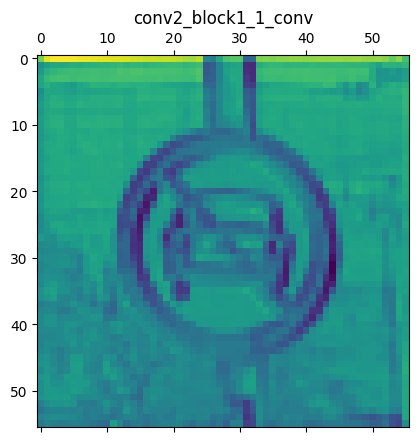

conv2_block1_1_bn (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

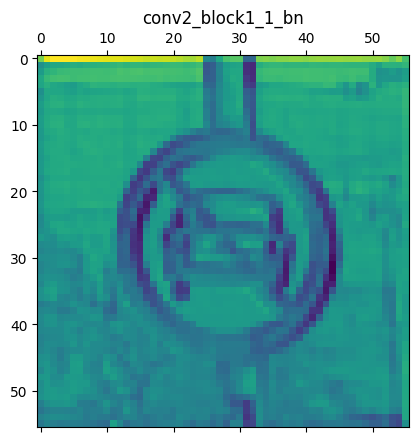

conv2_block1_1_relu (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

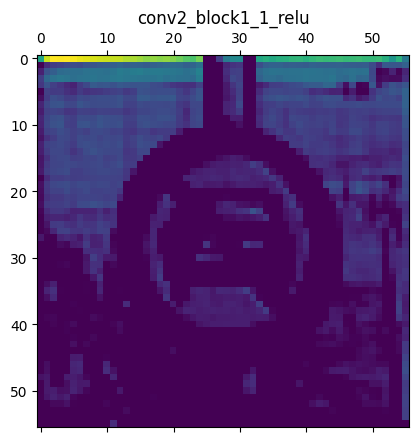

conv2_block1_2_conv (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

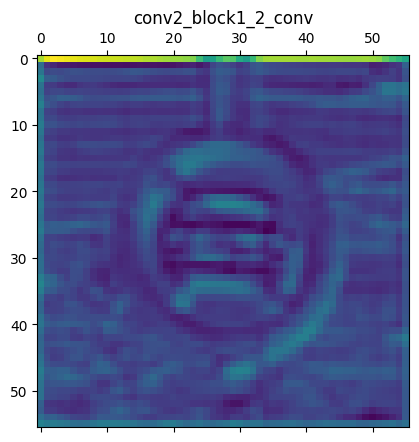

conv2_block1_2_bn (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

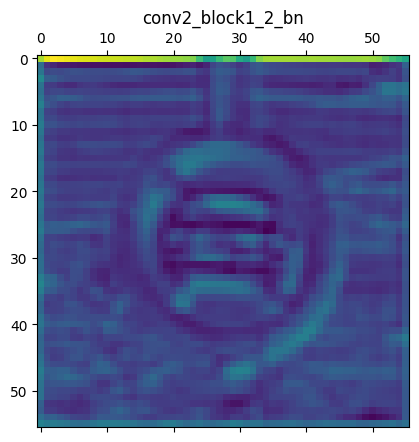

conv2_block1_2_relu (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

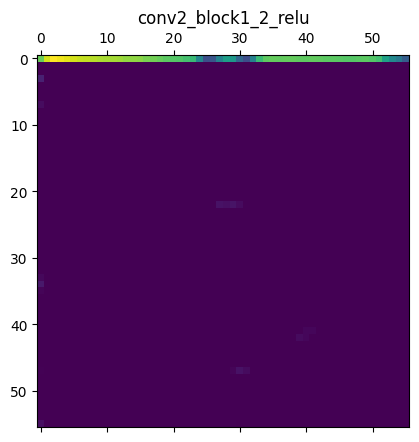

conv2_block1_0_conv (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

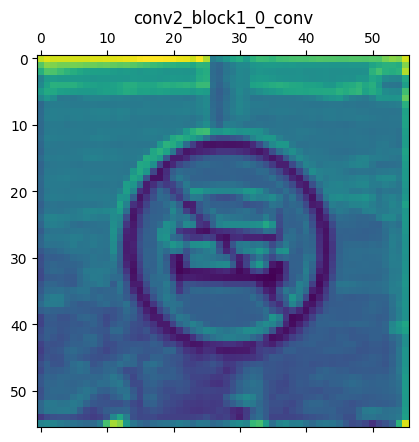

conv2_block1_3_conv (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

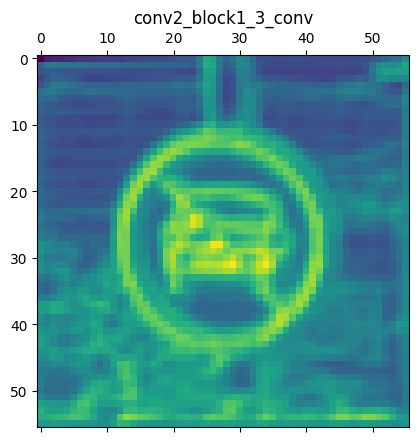

conv2_block1_0_bn (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

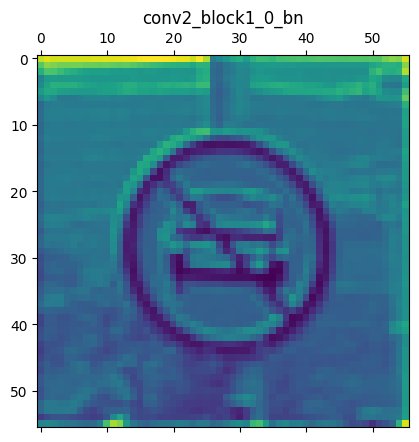

conv2_block1_3_bn (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

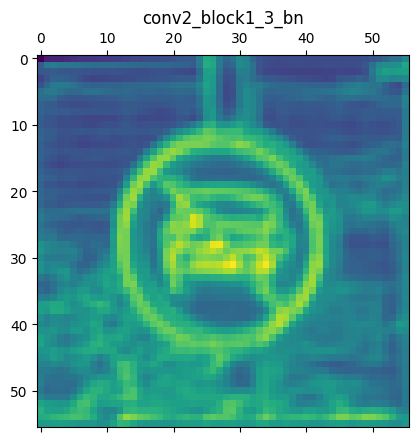

conv2_block1_add (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

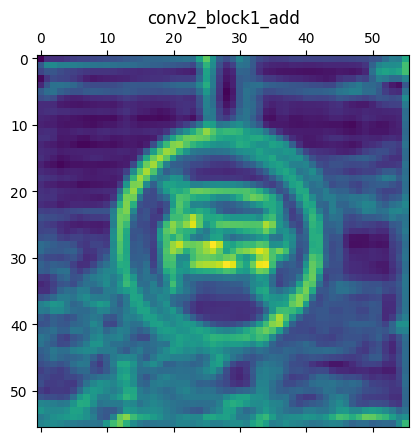

conv2_block1_out (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

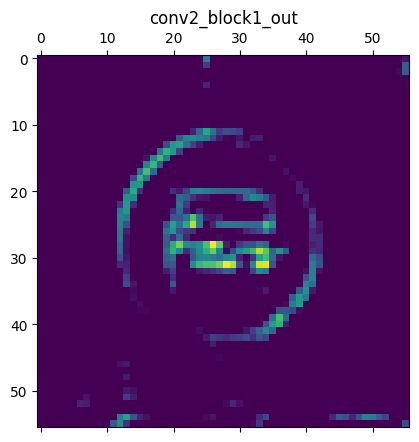

conv2_block2_1_conv (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

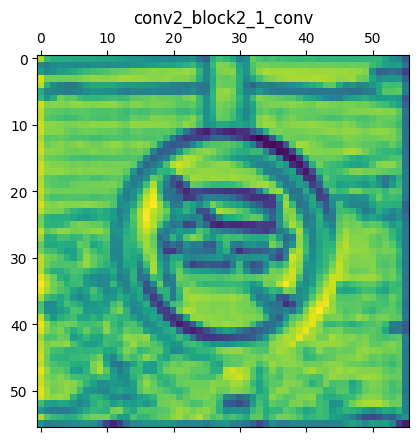

conv2_block2_1_bn (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

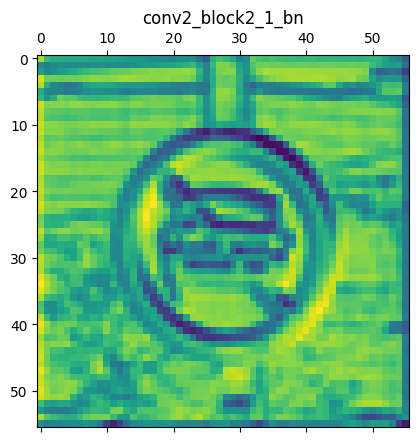

conv2_block2_1_relu (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

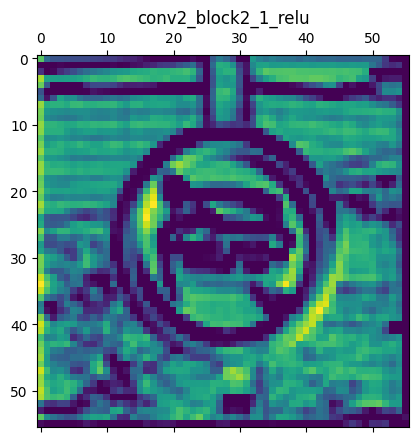

conv2_block2_2_conv (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

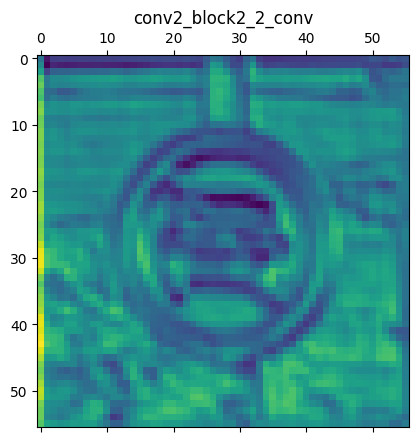

conv2_block2_2_bn (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

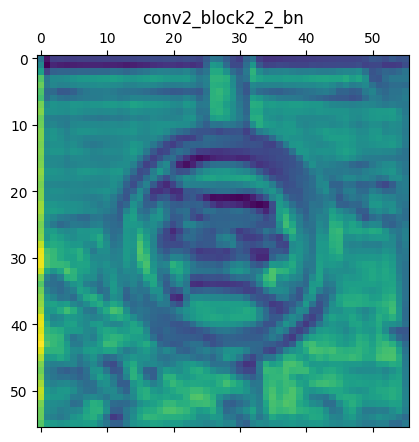

conv2_block2_2_relu (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

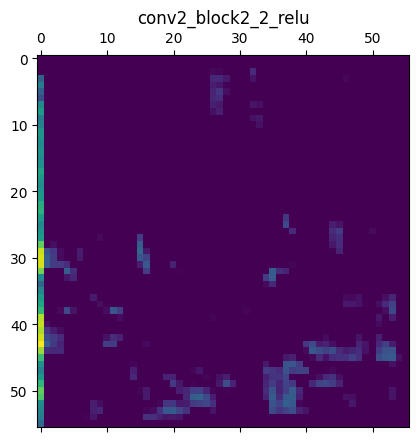

conv2_block2_3_conv (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

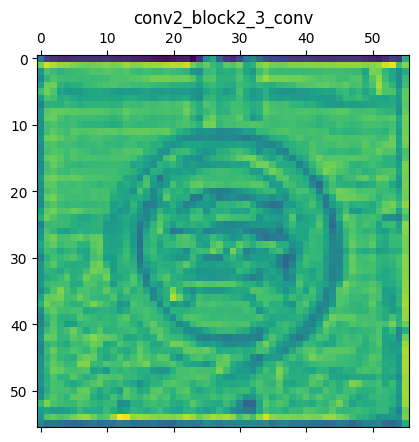

conv2_block2_3_bn (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

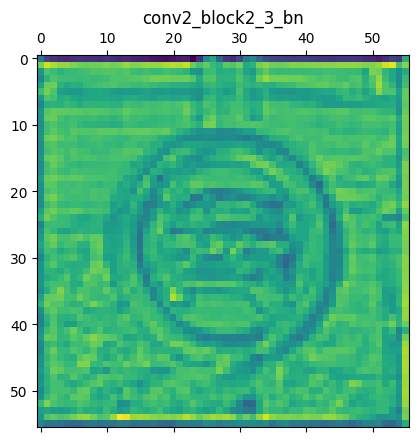

conv2_block2_add (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

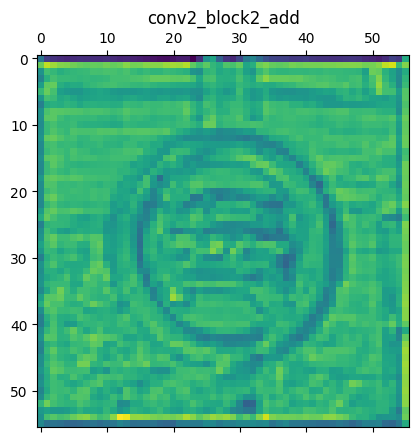

conv2_block2_out (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

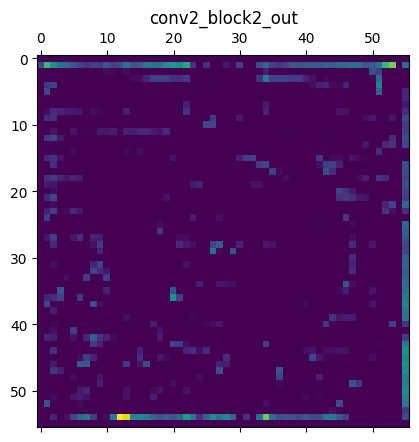

conv2_block3_1_conv (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

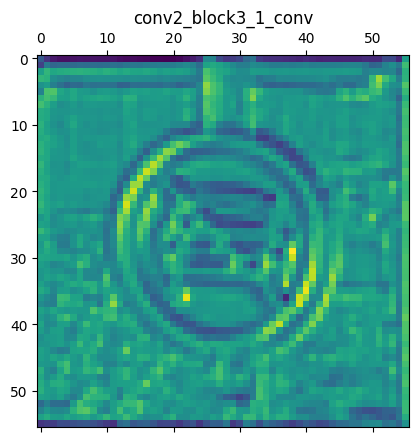

conv2_block3_1_bn (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

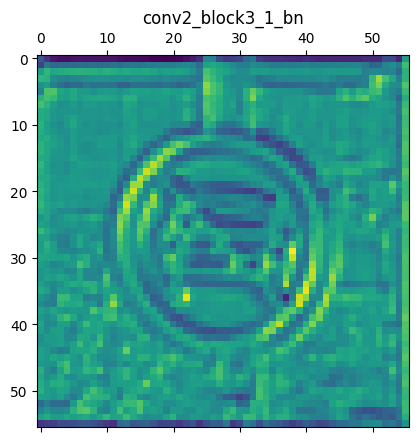

conv2_block3_1_relu (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

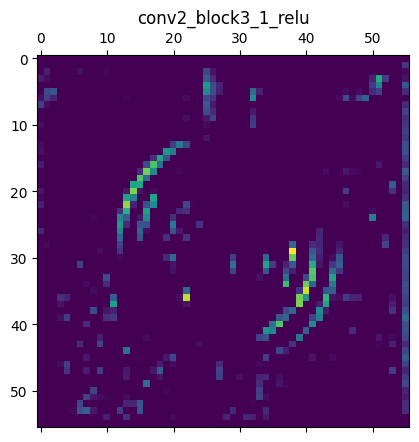

conv2_block3_2_conv (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

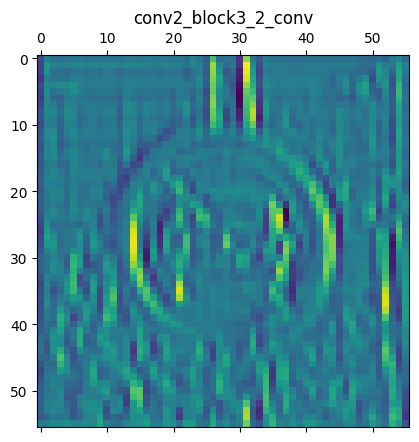

conv2_block3_2_bn (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

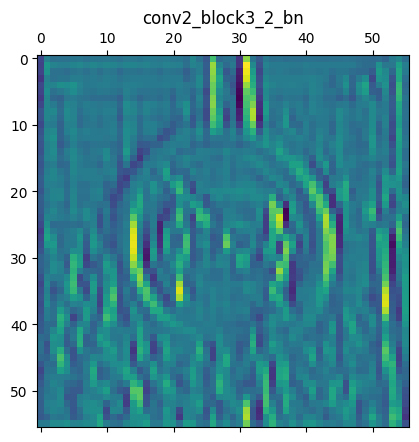

conv2_block3_2_relu (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

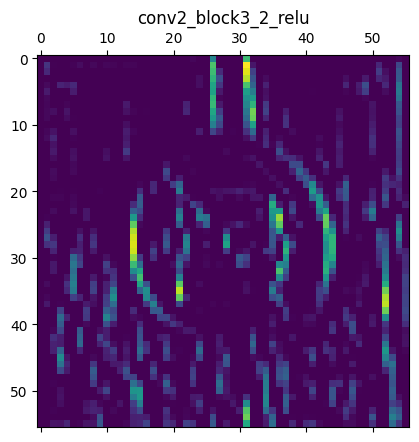

conv2_block3_3_conv (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

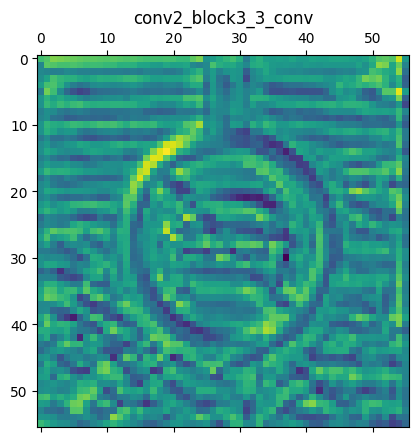

conv2_block3_3_bn (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

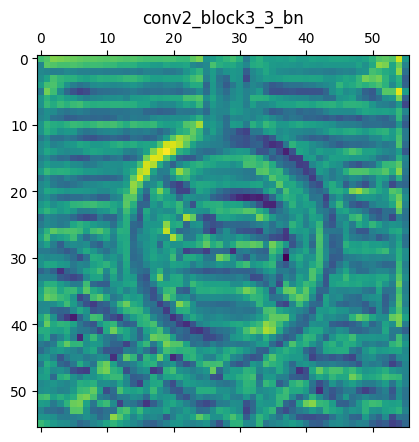

conv2_block3_add (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

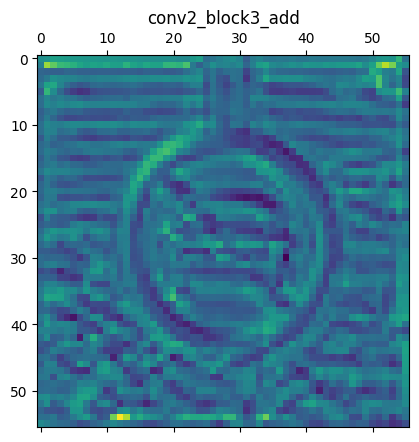

conv2_block3_out (1, 56, 56, 256)


<Figure size 640x480 with 0 Axes>

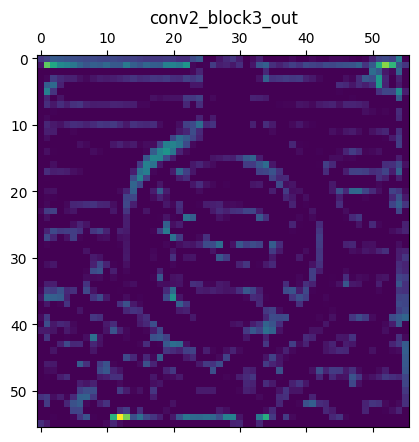

conv3_block1_1_conv (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

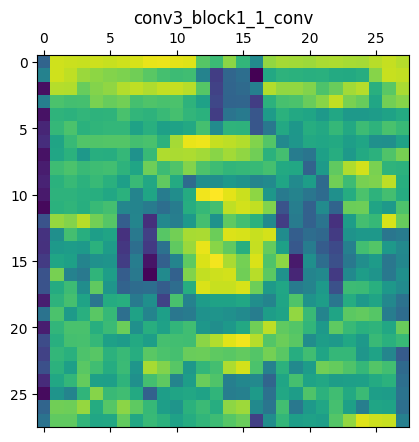

conv3_block1_1_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

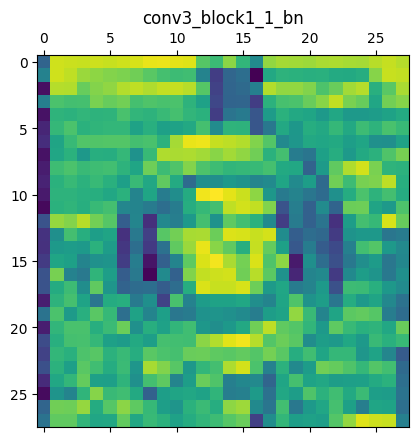

conv3_block1_1_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

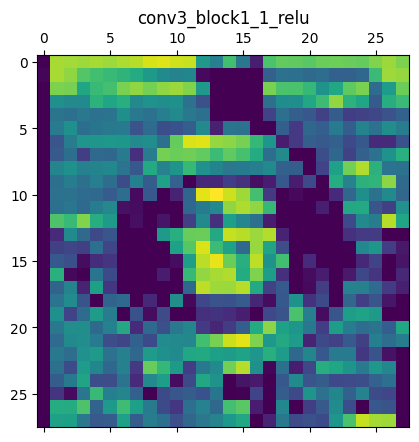

conv3_block1_2_conv (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

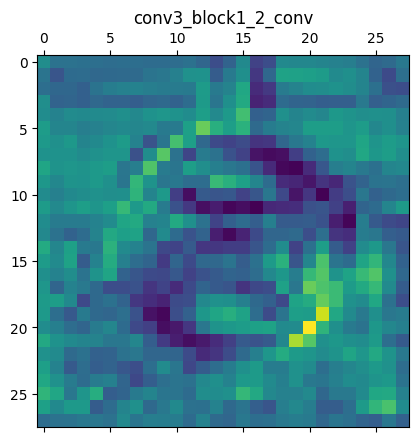

conv3_block1_2_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

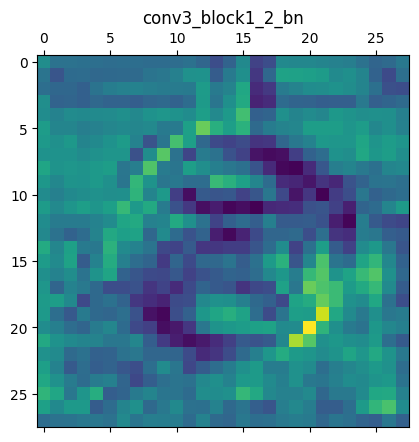

conv3_block1_2_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

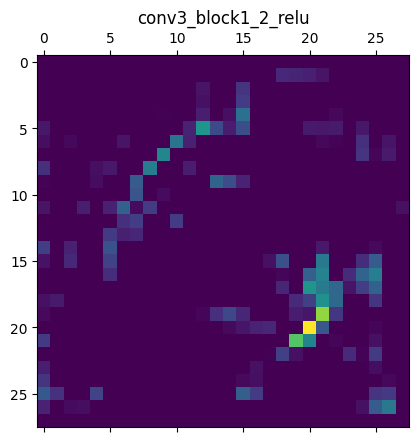

conv3_block1_0_conv (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

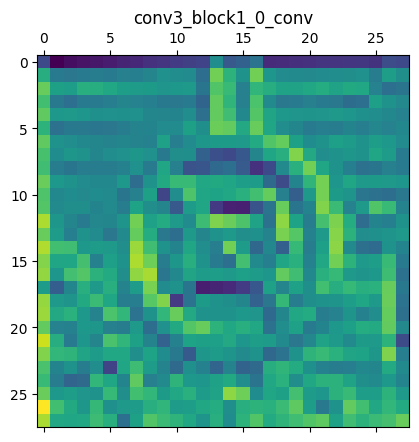

conv3_block1_3_conv (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

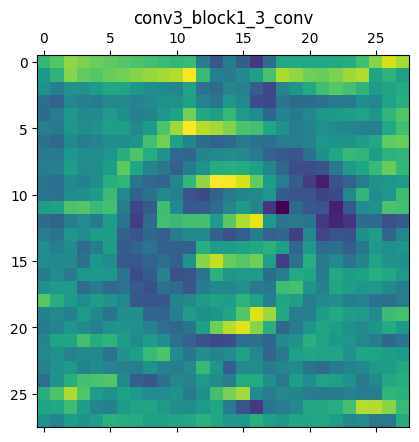

conv3_block1_0_bn (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

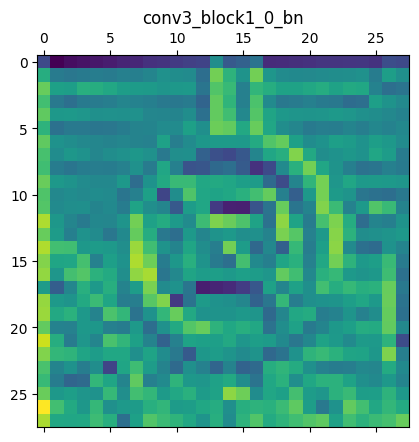

conv3_block1_3_bn (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

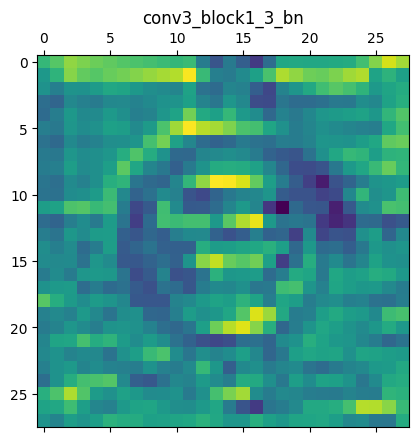

conv3_block1_add (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

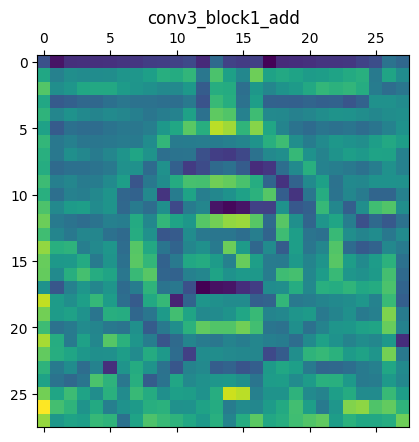

conv3_block1_out (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

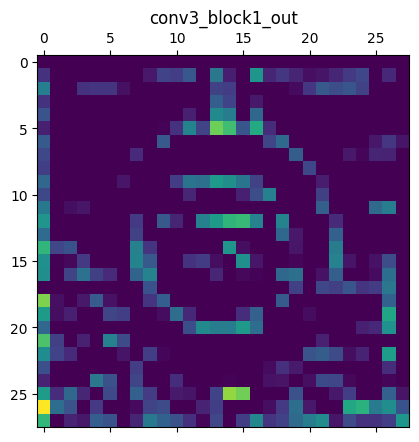

conv3_block2_1_conv (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

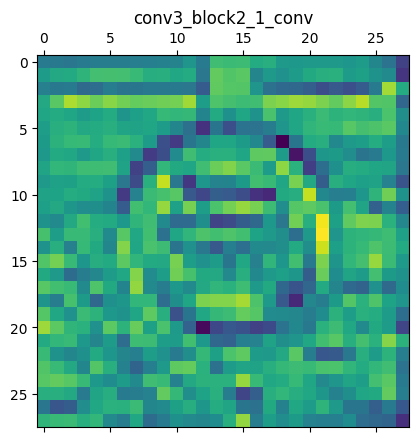

conv3_block2_1_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

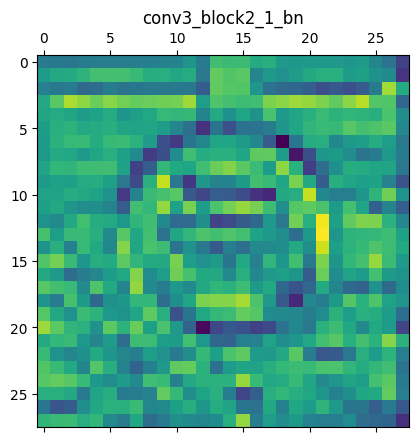

conv3_block2_1_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

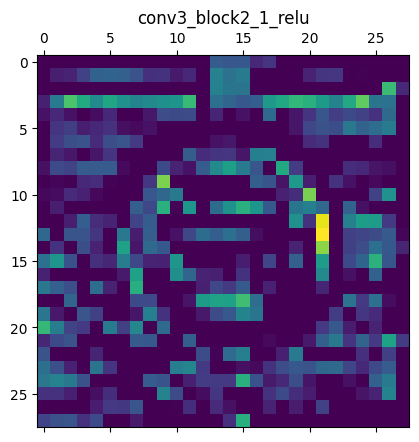

conv3_block2_2_conv (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

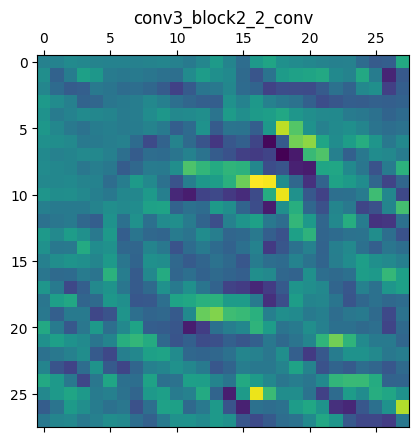

conv3_block2_2_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

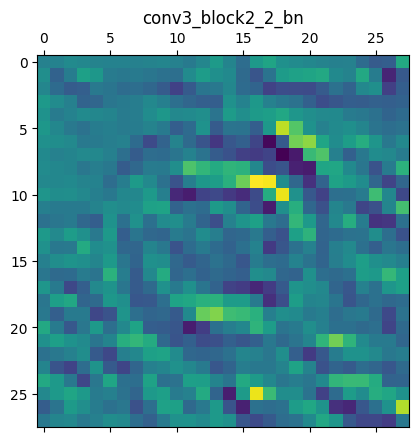

conv3_block2_2_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

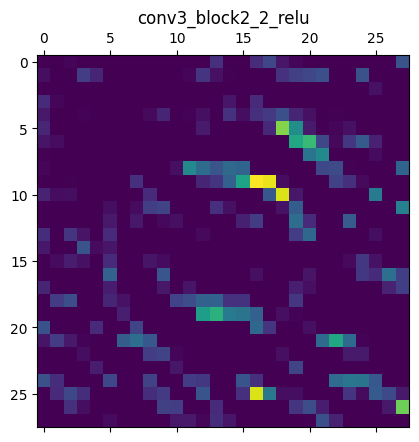

conv3_block2_3_conv (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

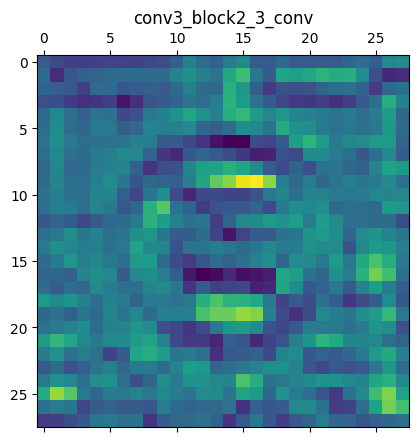

conv3_block2_3_bn (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

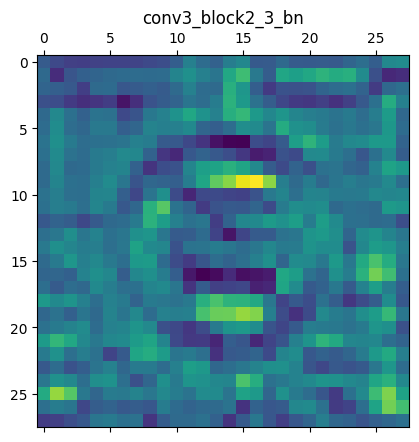

conv3_block2_add (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

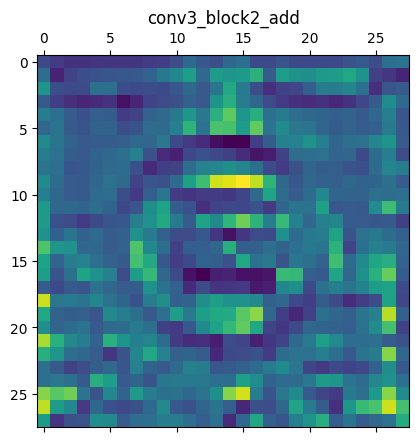

conv3_block2_out (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

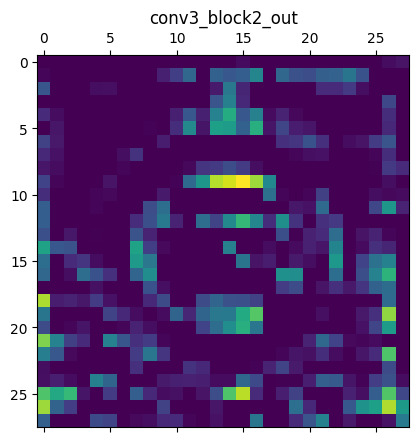

conv3_block3_1_conv (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

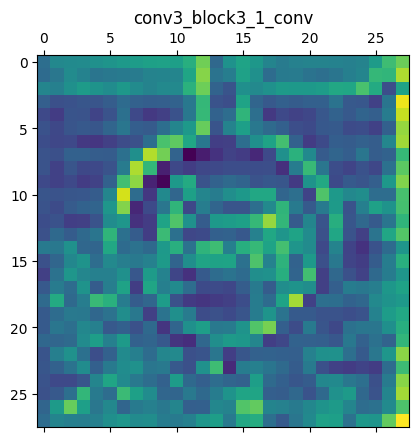

conv3_block3_1_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

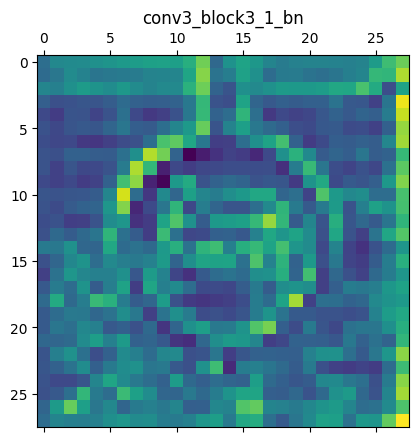

conv3_block3_1_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

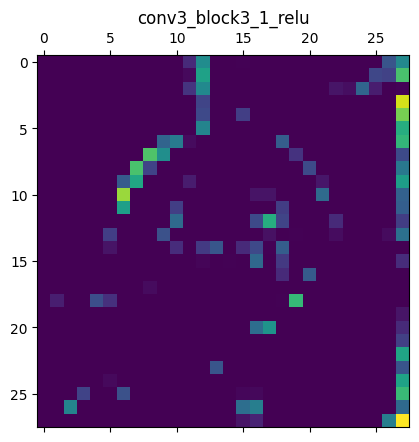

conv3_block3_2_conv (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

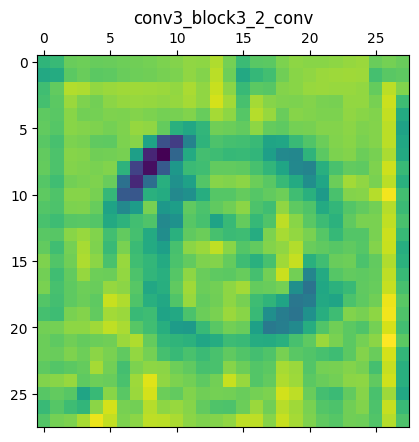

conv3_block3_2_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

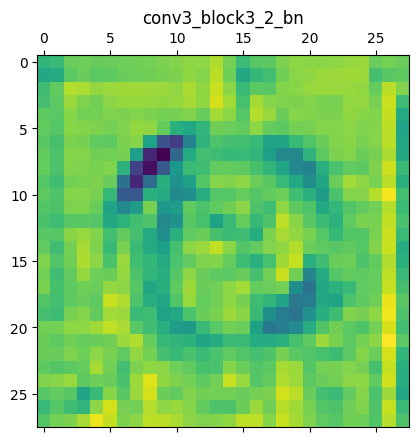

conv3_block3_2_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

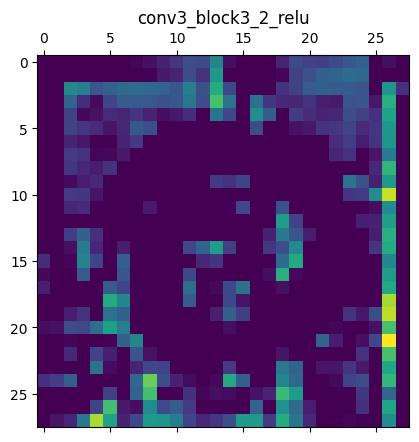

conv3_block3_3_conv (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

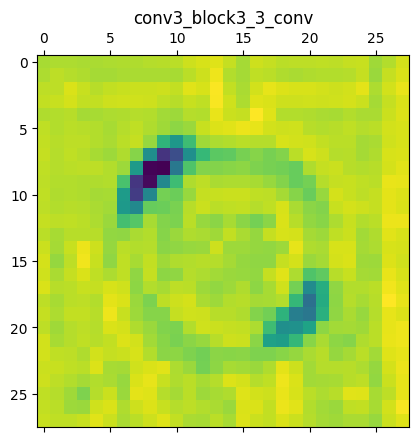

conv3_block3_3_bn (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

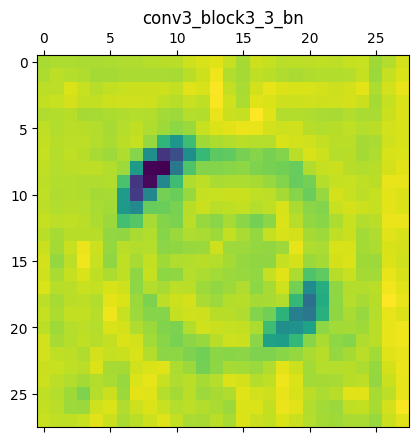

conv3_block3_add (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

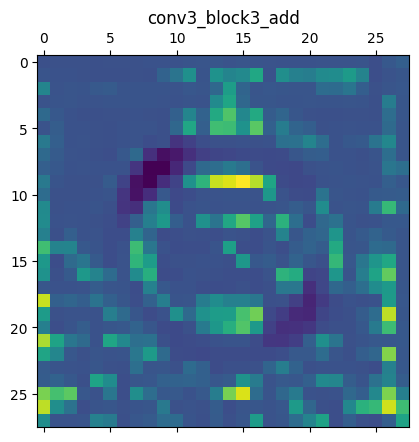

conv3_block3_out (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

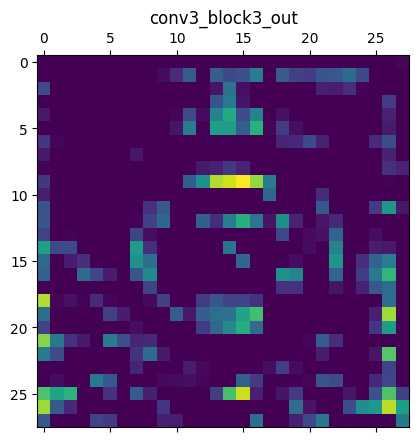

conv3_block4_1_conv (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

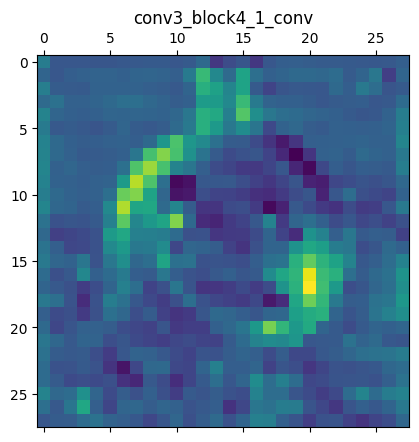

conv3_block4_1_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

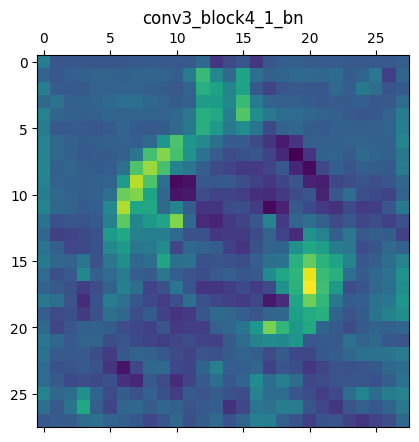

conv3_block4_1_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

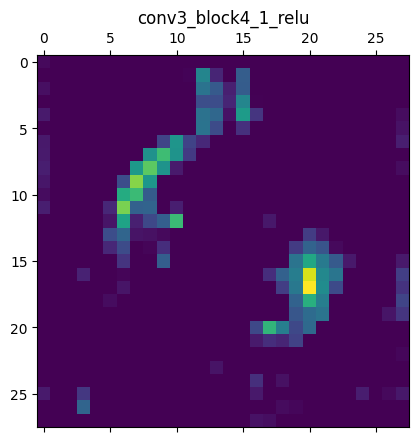

conv3_block4_2_conv (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

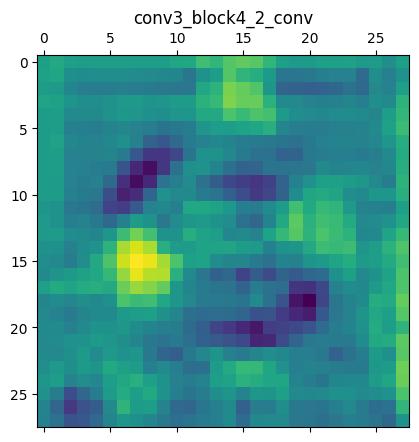

conv3_block4_2_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

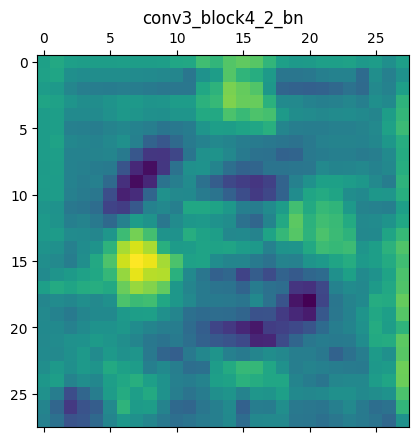

conv3_block4_2_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

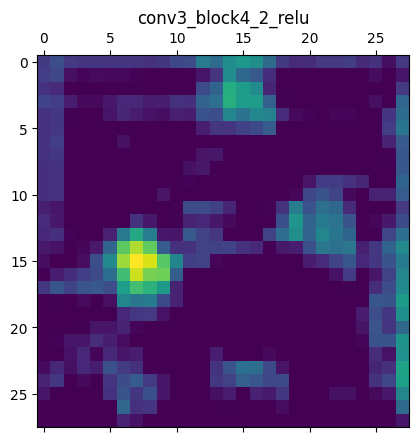

conv3_block4_3_conv (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

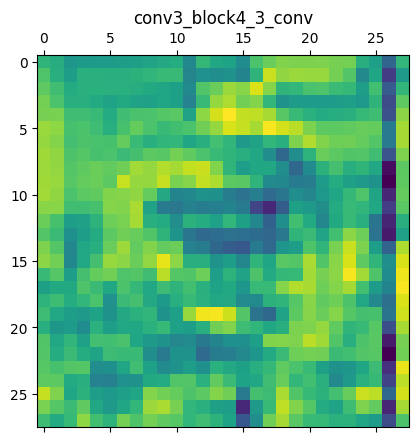

conv3_block4_3_bn (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

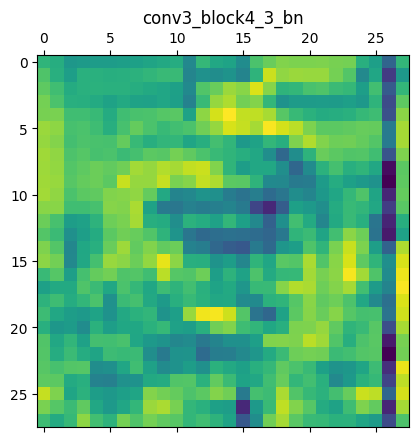

conv3_block4_add (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

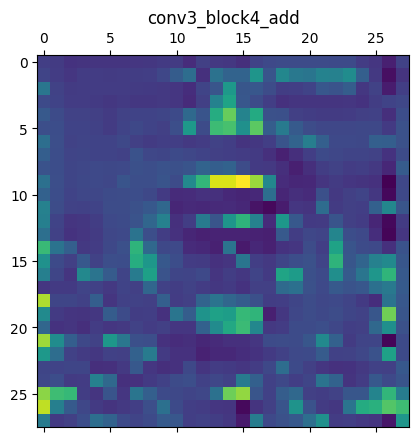

conv3_block4_out (1, 28, 28, 512)


<Figure size 640x480 with 0 Axes>

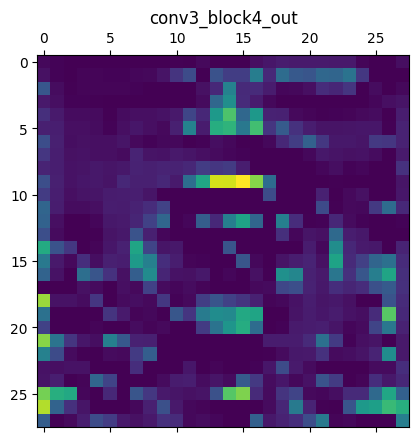

conv4_block1_1_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

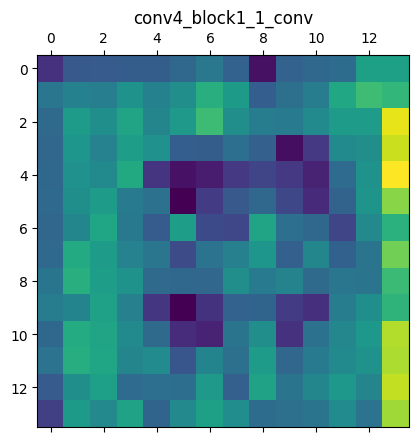

conv4_block1_1_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

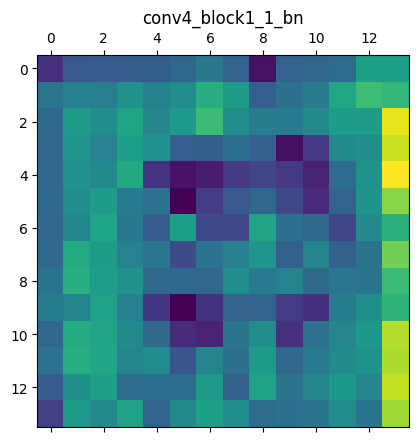

conv4_block1_1_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

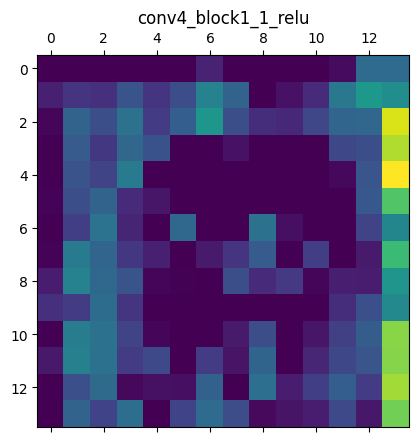

conv4_block1_2_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

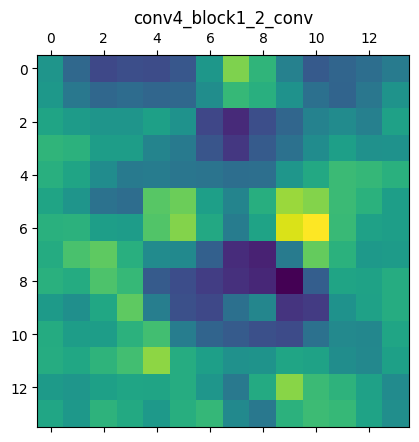

conv4_block1_2_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

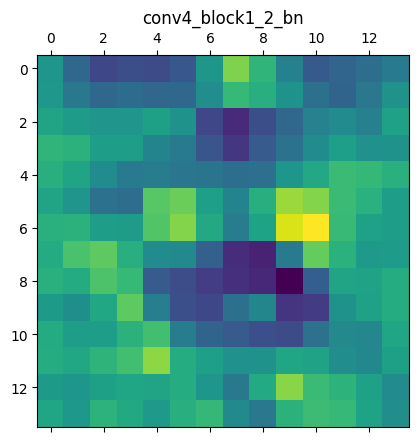

conv4_block1_2_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

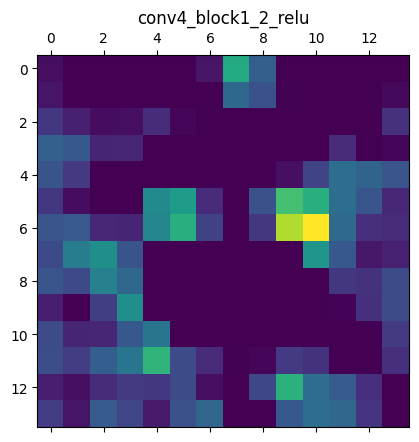

conv4_block1_0_conv (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

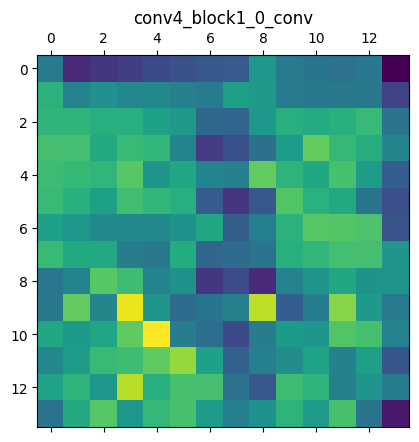

conv4_block1_3_conv (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

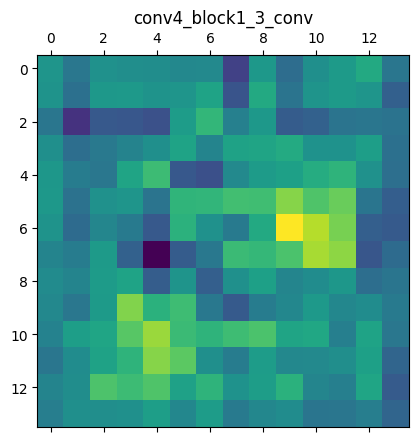

conv4_block1_0_bn (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

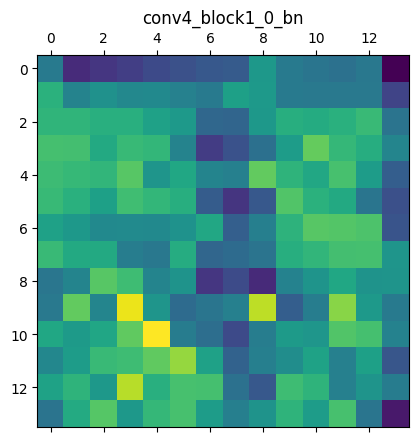

conv4_block1_3_bn (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

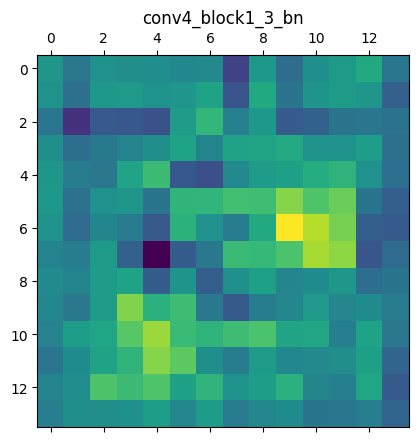

conv4_block1_add (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

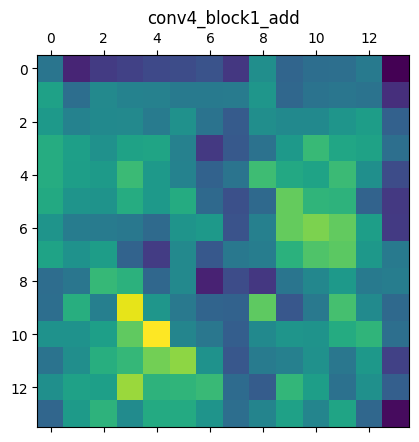

conv4_block1_out (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

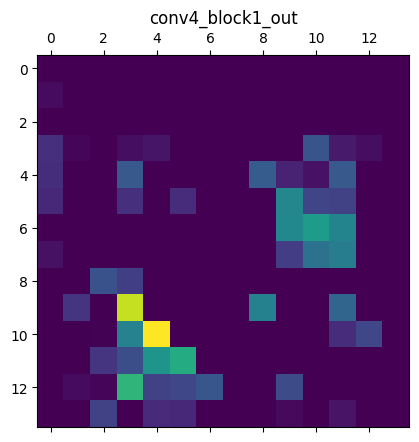

conv4_block2_1_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

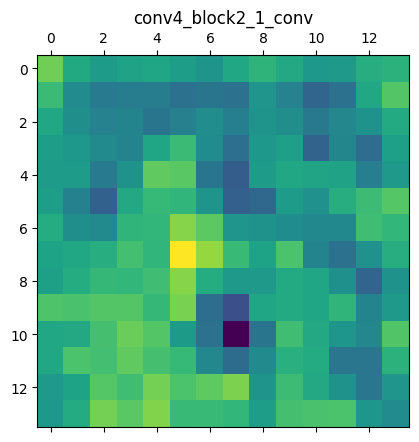

conv4_block2_1_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

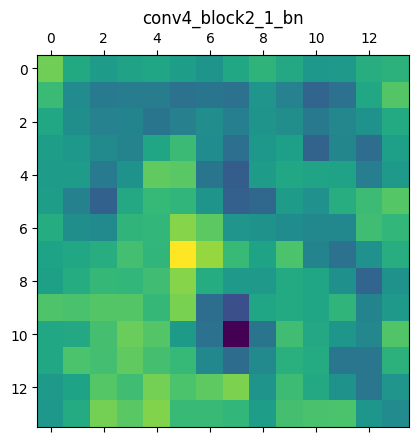

conv4_block2_1_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

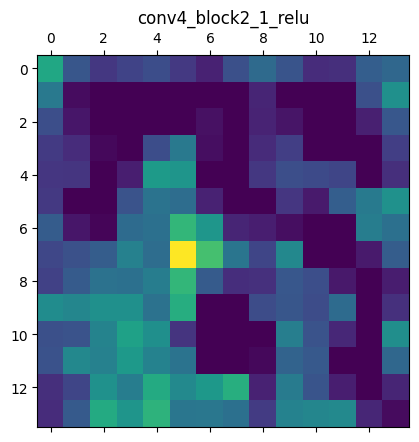

conv4_block2_2_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

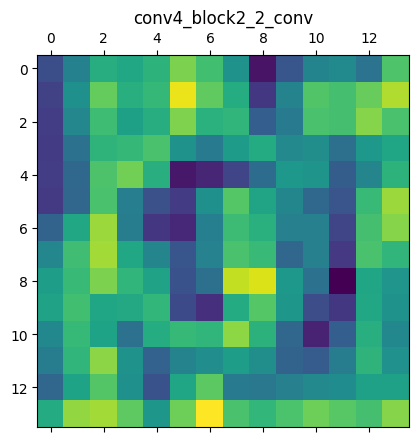

conv4_block2_2_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

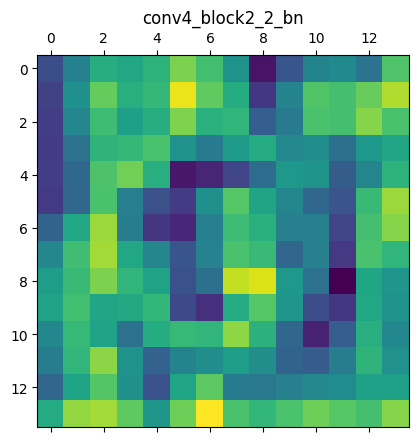

conv4_block2_2_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

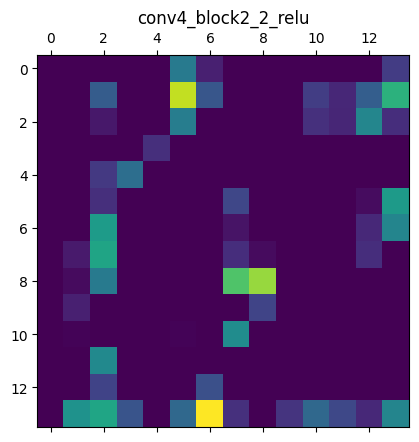

conv4_block2_3_conv (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

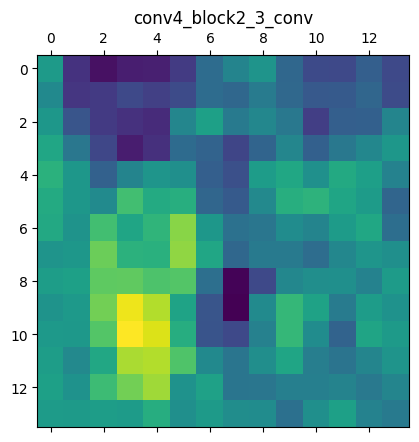

conv4_block2_3_bn (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

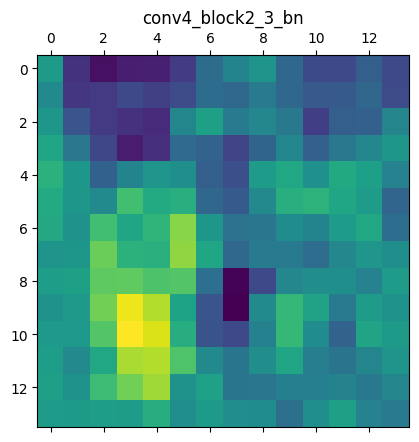

conv4_block2_add (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

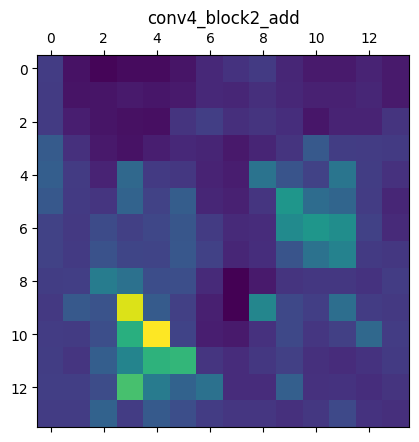

conv4_block2_out (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

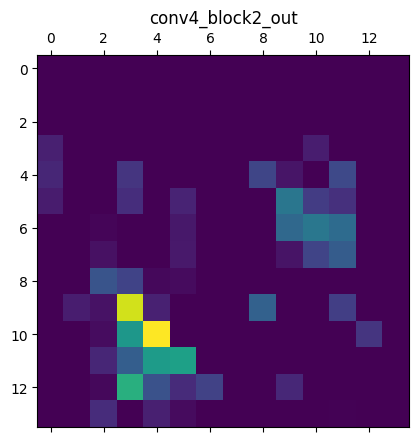

conv4_block3_1_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

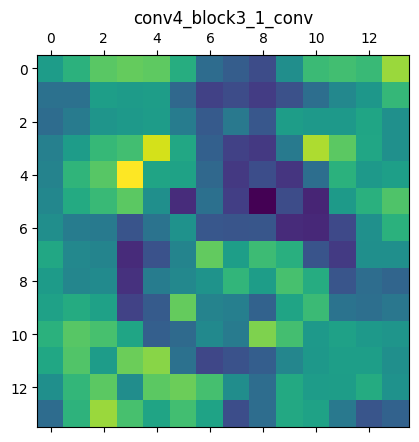

conv4_block3_1_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

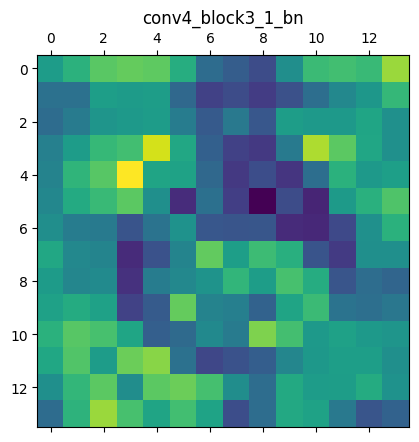

conv4_block3_1_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

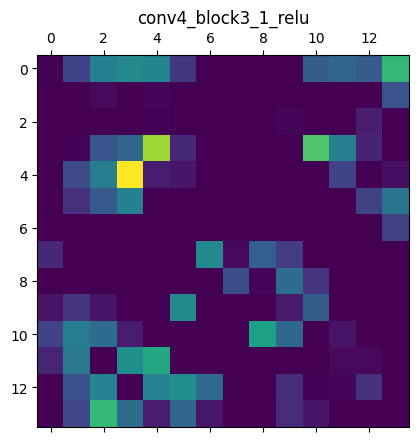

conv4_block3_2_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

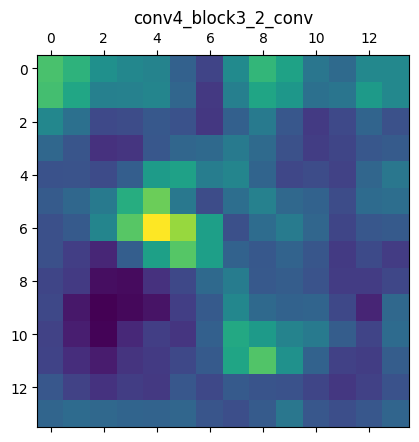

conv4_block3_2_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

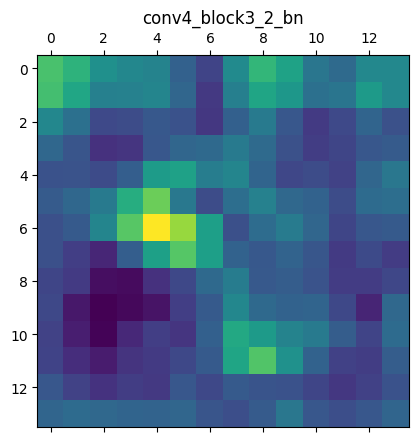

conv4_block3_2_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

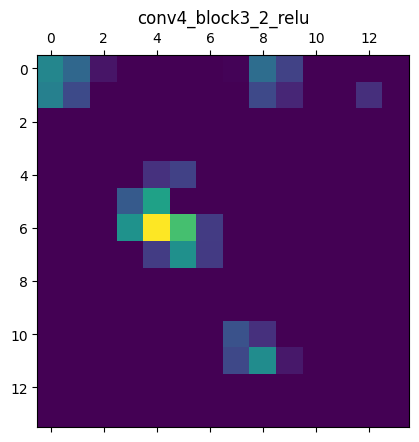

conv4_block3_3_conv (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

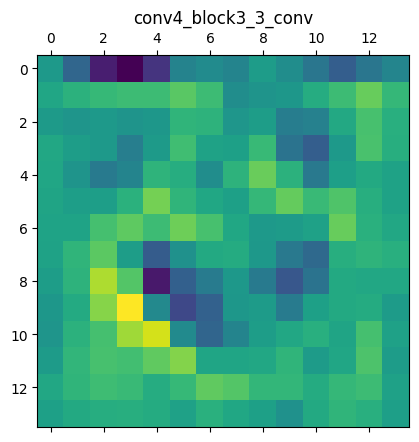

conv4_block3_3_bn (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

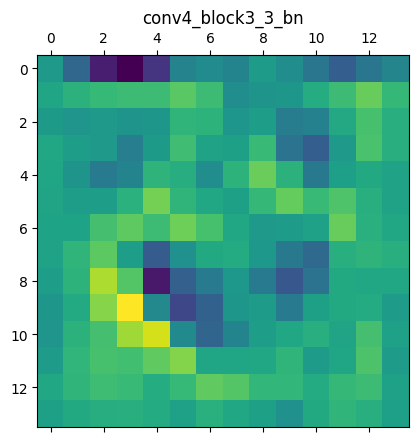

conv4_block3_add (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

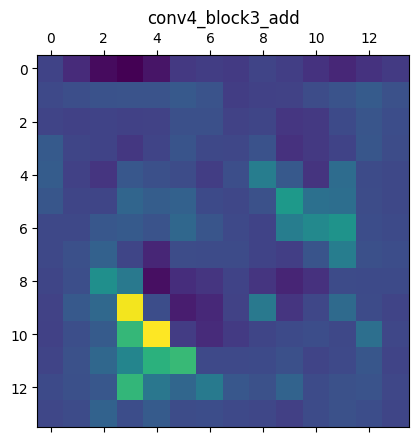

conv4_block3_out (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

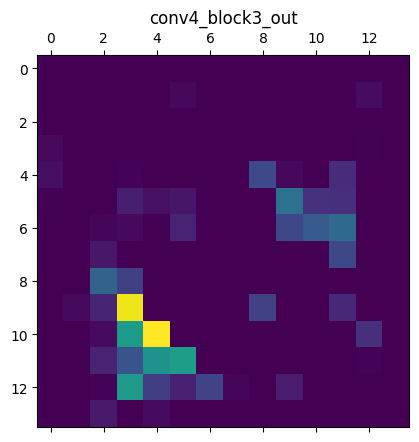

conv4_block4_1_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

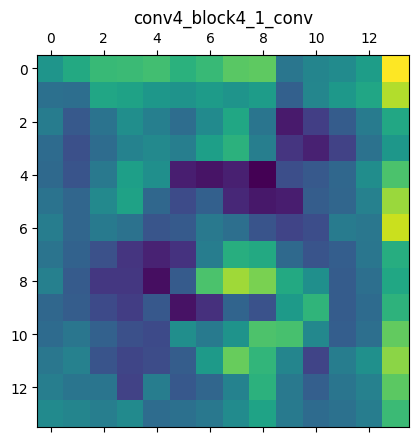

conv4_block4_1_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

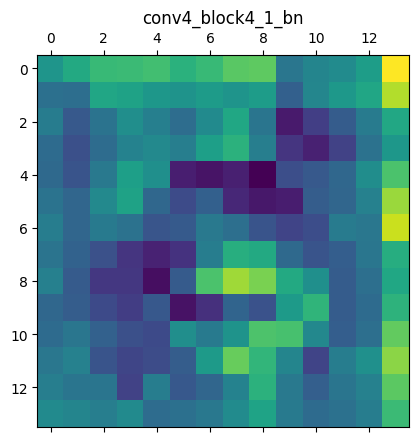

conv4_block4_1_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

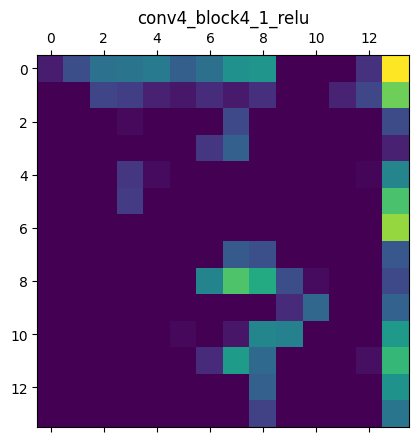

conv4_block4_2_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

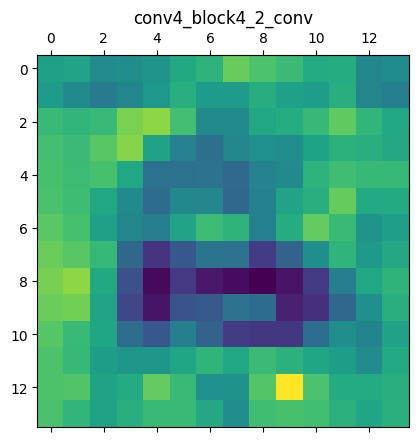

conv4_block4_2_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

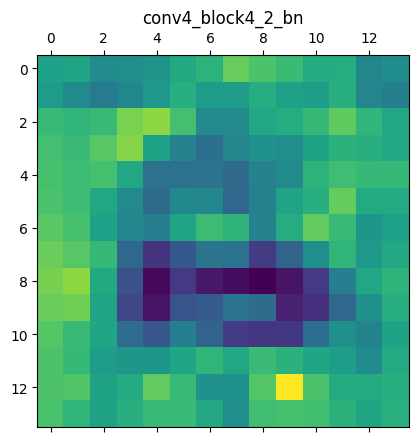

conv4_block4_2_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

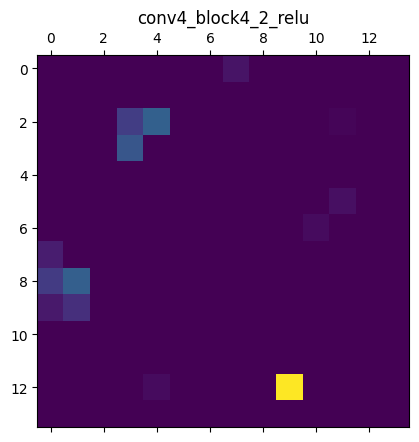

conv4_block4_3_conv (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

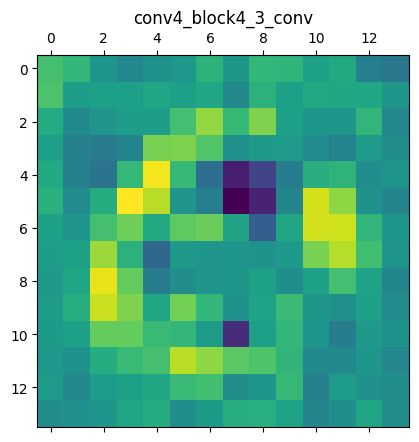

conv4_block4_3_bn (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

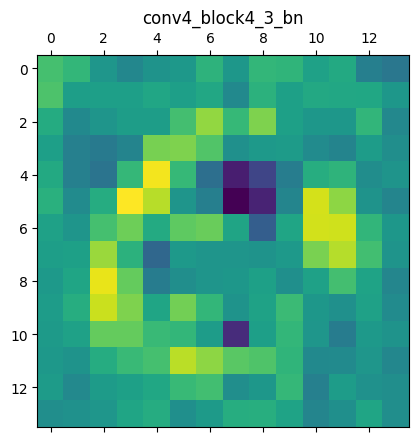

conv4_block4_add (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

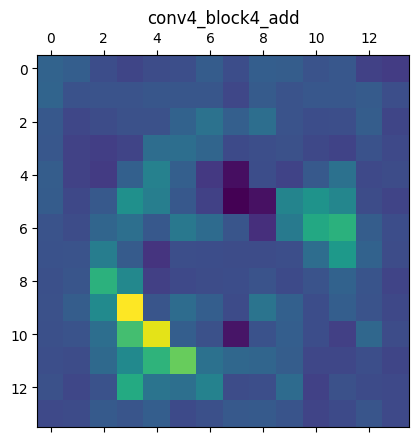

conv4_block4_out (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

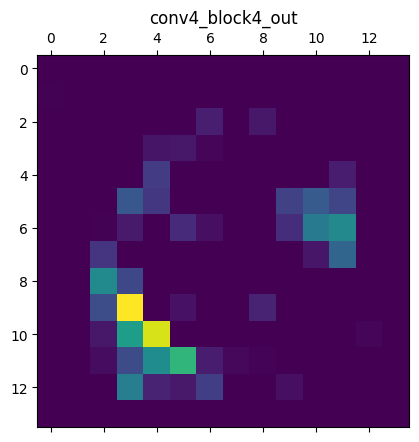

conv4_block5_1_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

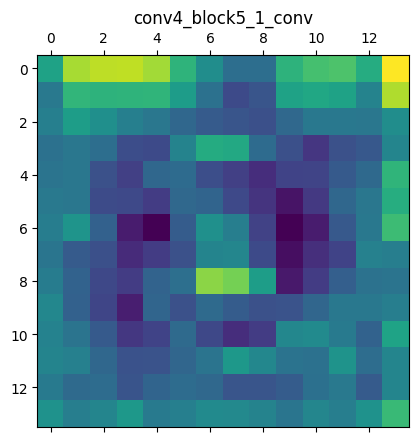

conv4_block5_1_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

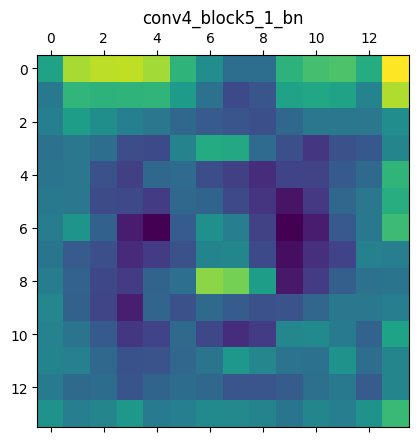

conv4_block5_1_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

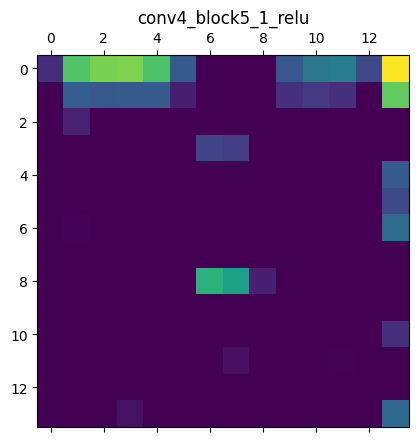

conv4_block5_2_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

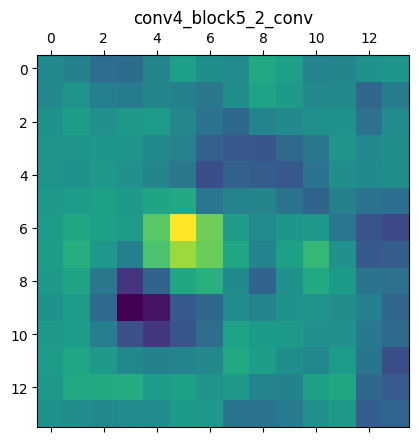

conv4_block5_2_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

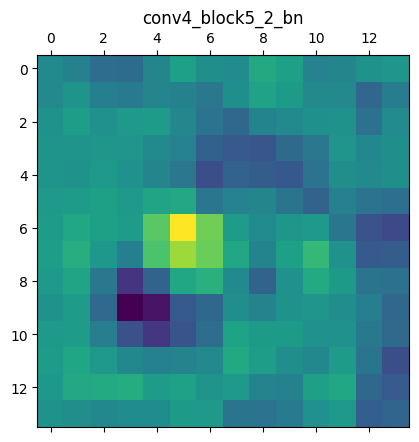

conv4_block5_2_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

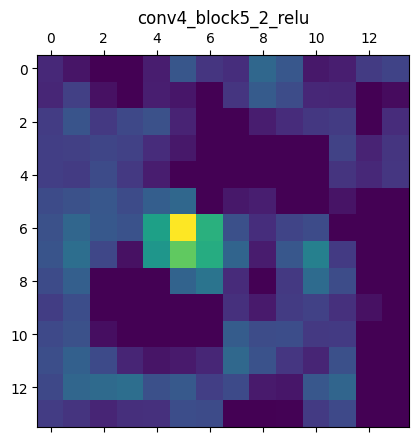

conv4_block5_3_conv (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

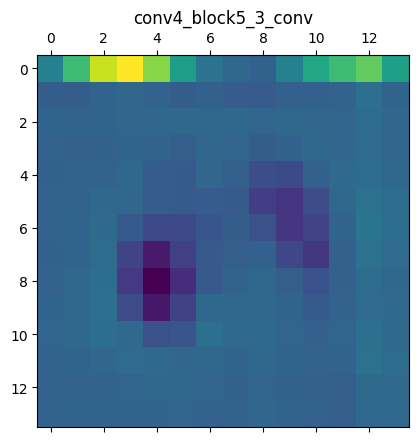

conv4_block5_3_bn (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

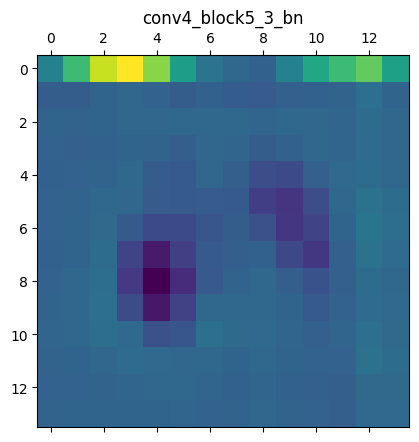

conv4_block5_add (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

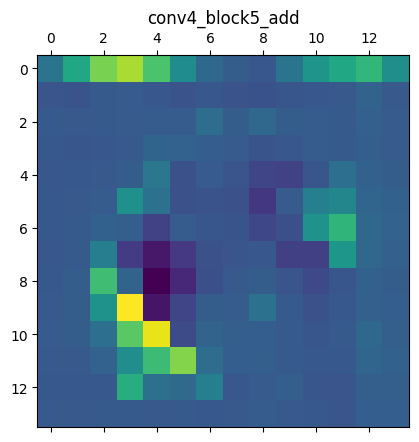

conv4_block5_out (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

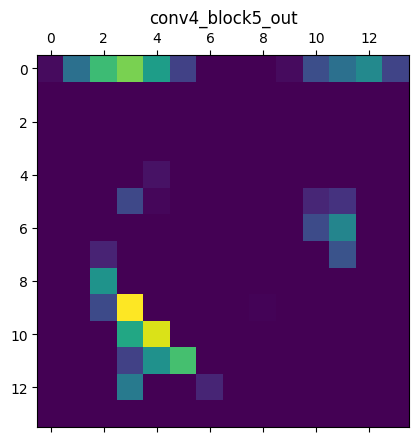

conv4_block6_1_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

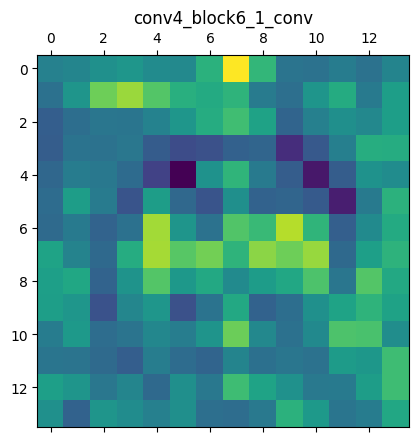

conv4_block6_1_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

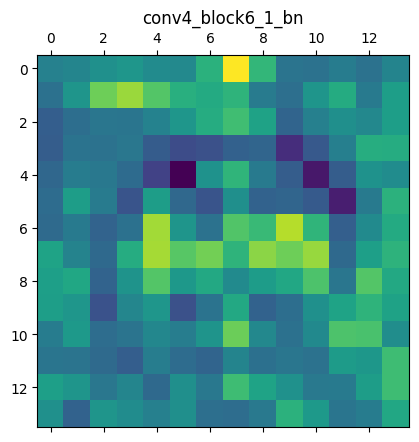

conv4_block6_1_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

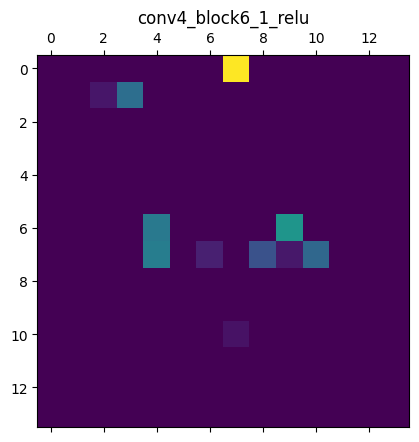

conv4_block6_2_conv (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

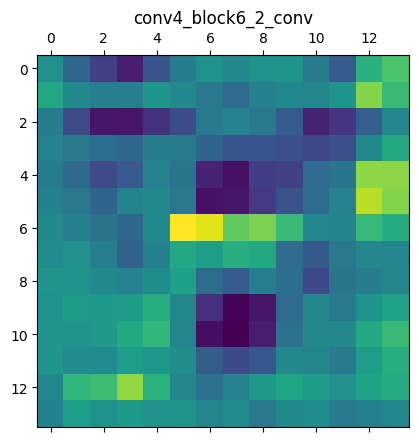

conv4_block6_2_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

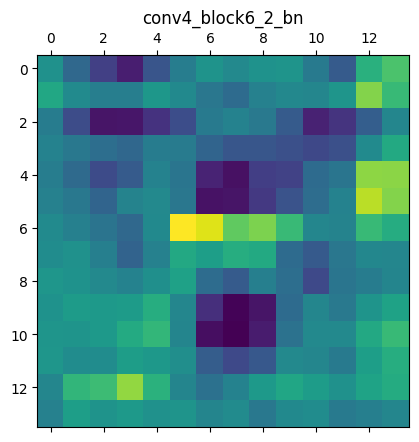

conv4_block6_2_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

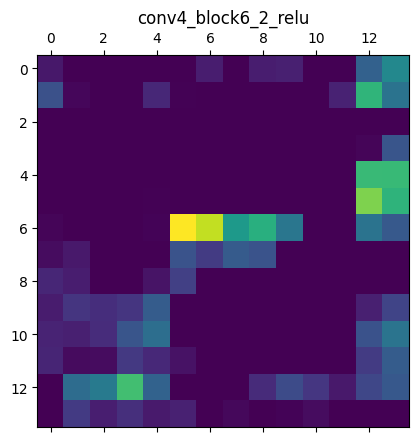

conv4_block6_3_conv (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

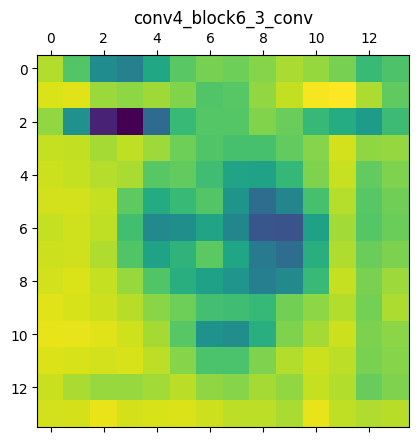

conv4_block6_3_bn (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

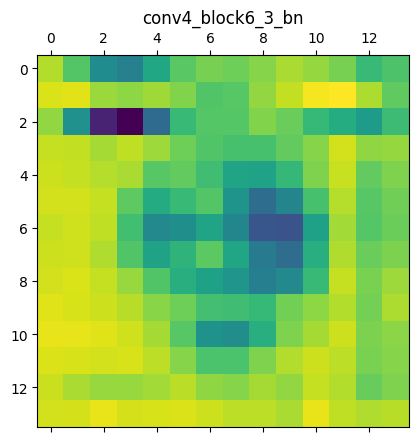

conv4_block6_add (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

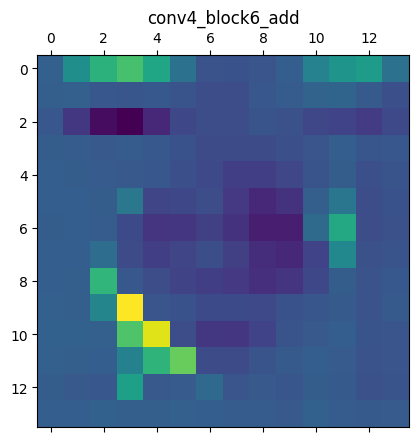

conv4_block6_out (1, 14, 14, 1024)


<Figure size 640x480 with 0 Axes>

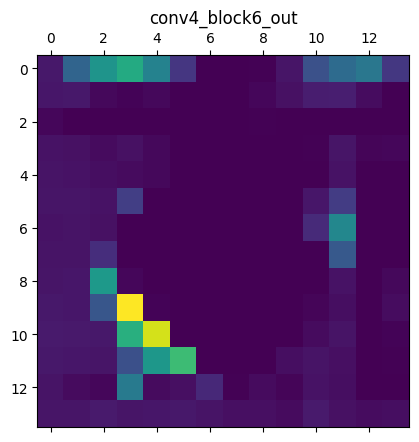

conv5_block1_1_conv (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

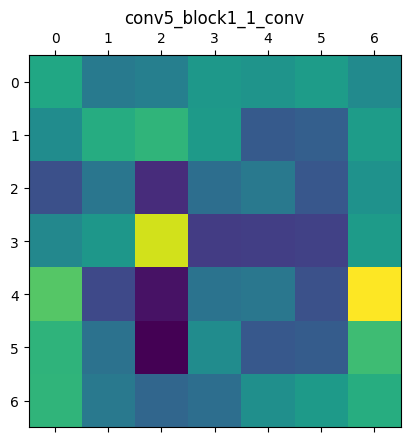

conv5_block1_1_bn (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

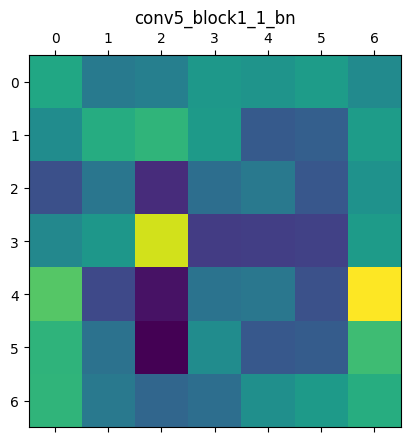

conv5_block1_1_relu (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

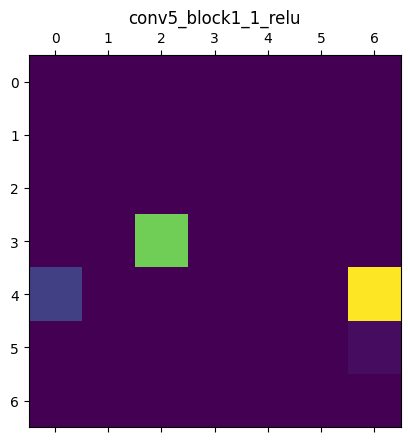

conv5_block1_2_conv (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

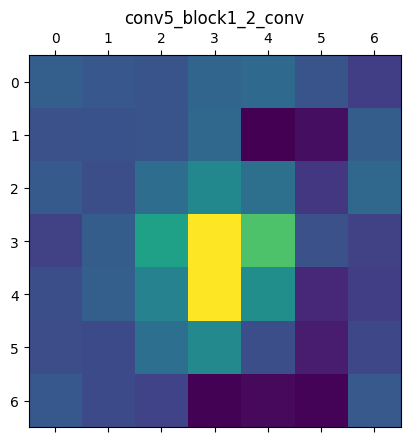

conv5_block1_2_bn (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

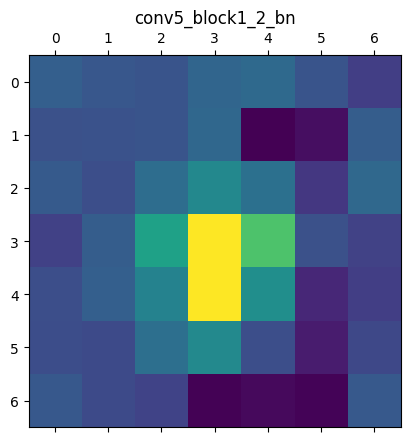

conv5_block1_2_relu (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

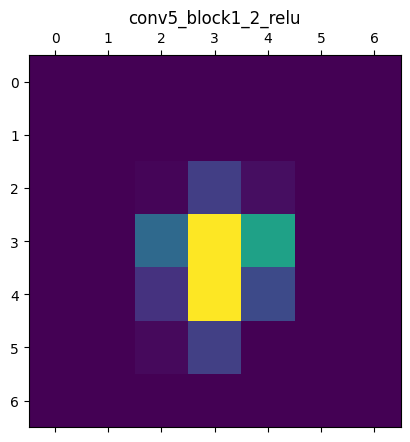

conv5_block1_0_conv (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

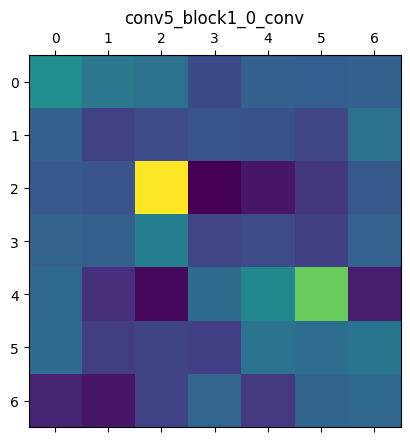

conv5_block1_3_conv (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

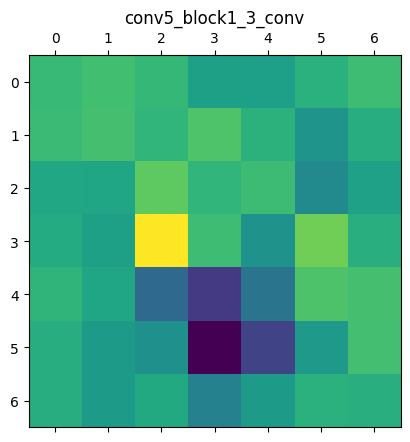

conv5_block1_0_bn (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

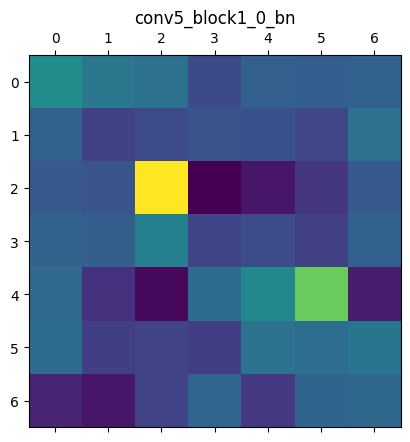

conv5_block1_3_bn (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

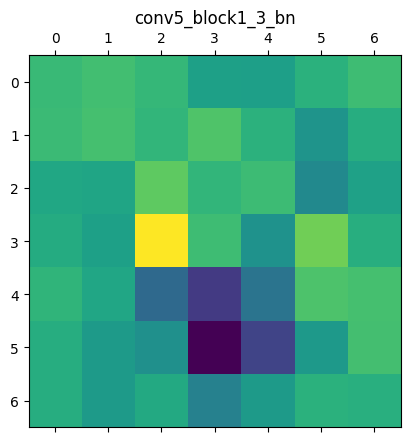

conv5_block1_add (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

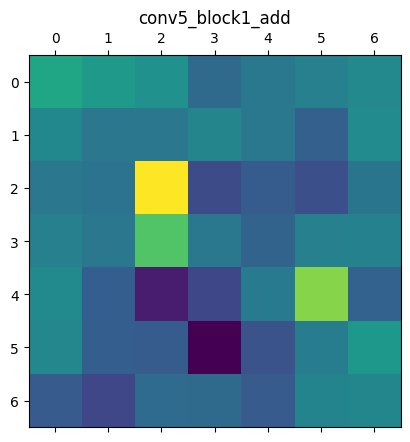

conv5_block1_out (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

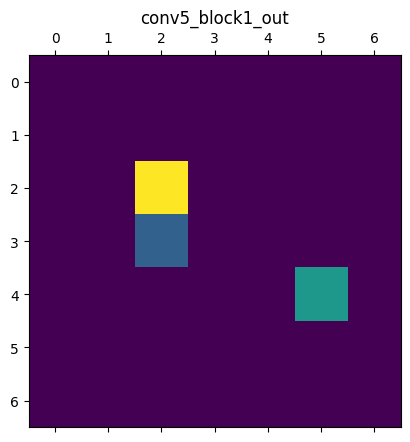

conv5_block2_1_conv (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

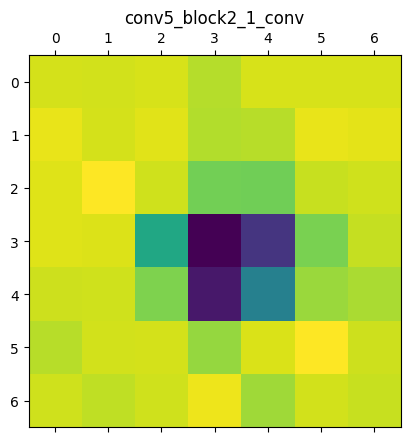

conv5_block2_1_bn (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

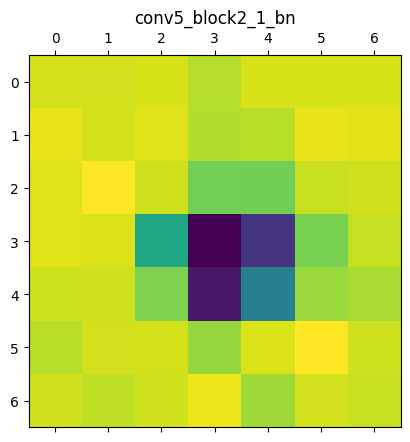

conv5_block2_1_relu (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

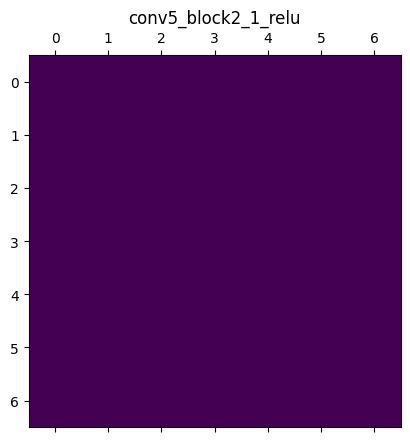

conv5_block2_2_conv (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

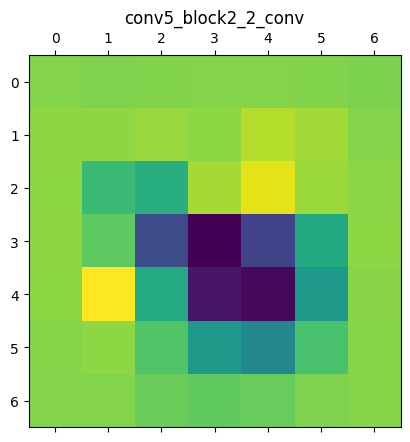

conv5_block2_2_bn (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

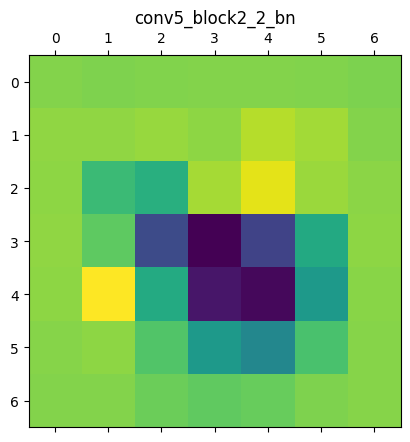

conv5_block2_2_relu (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

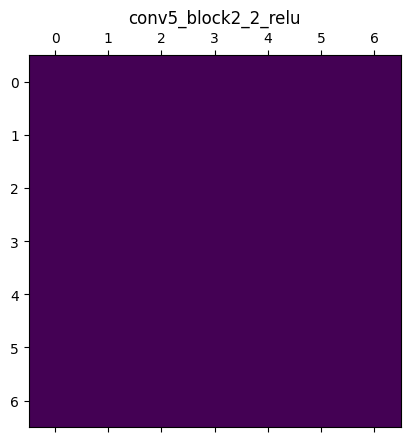

conv5_block2_3_conv (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

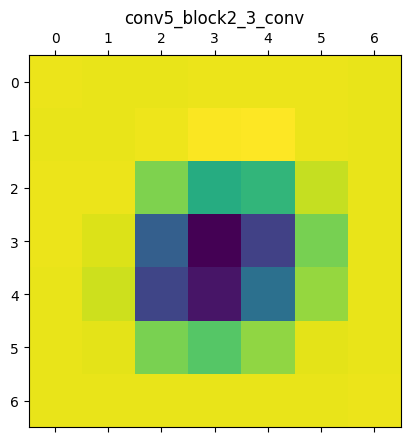

conv5_block2_3_bn (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

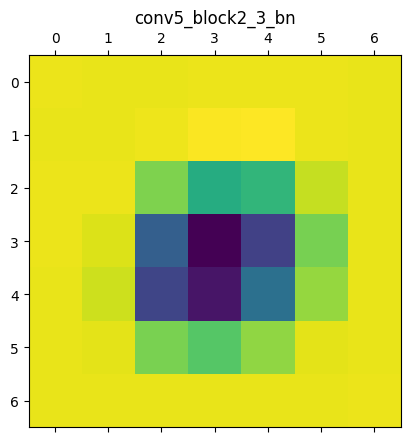

conv5_block2_add (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

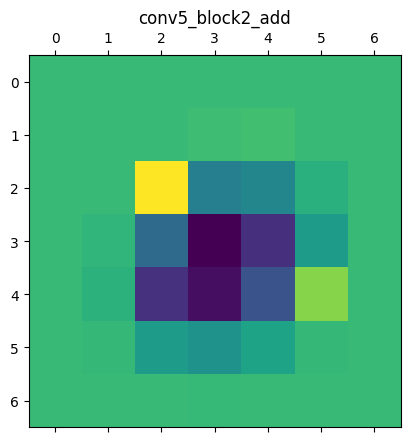

conv5_block2_out (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

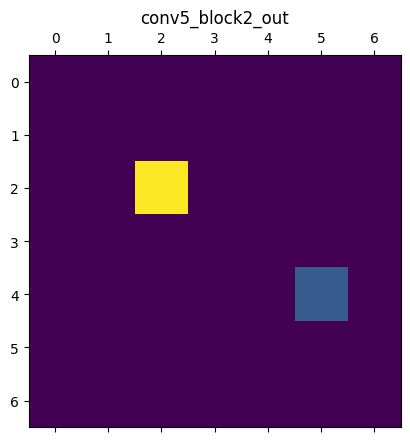

conv5_block3_1_conv (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

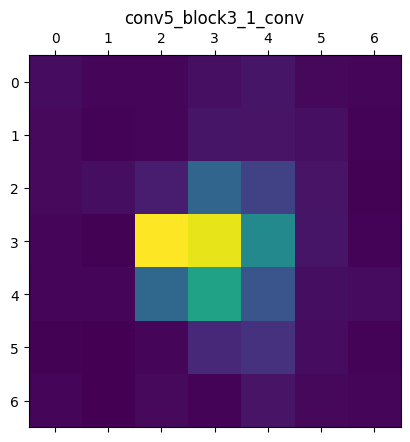

conv5_block3_1_bn (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

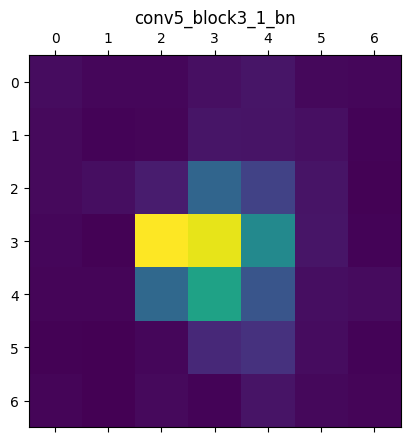

conv5_block3_1_relu (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

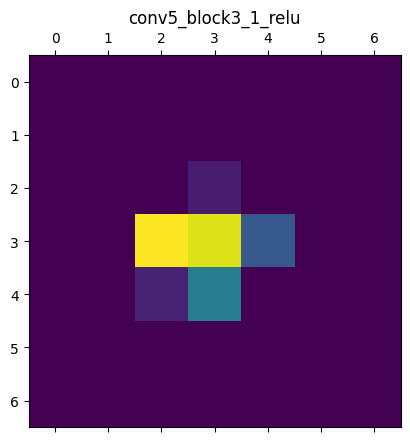

conv5_block3_2_conv (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

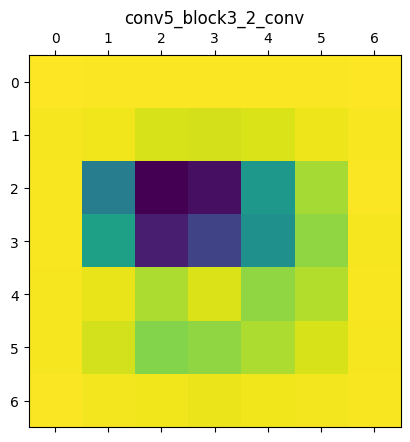

conv5_block3_2_bn (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

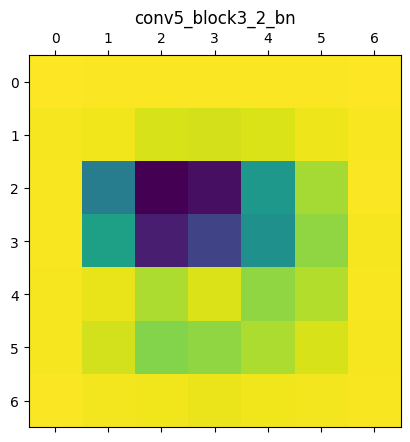

conv5_block3_2_relu (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

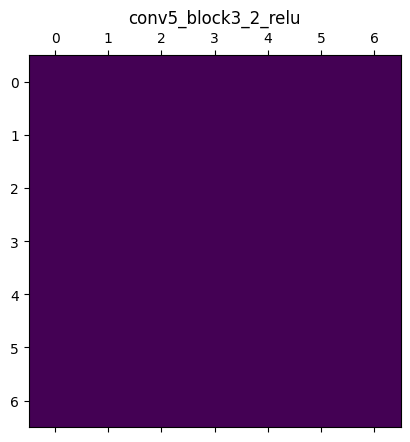

conv5_block3_3_conv (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

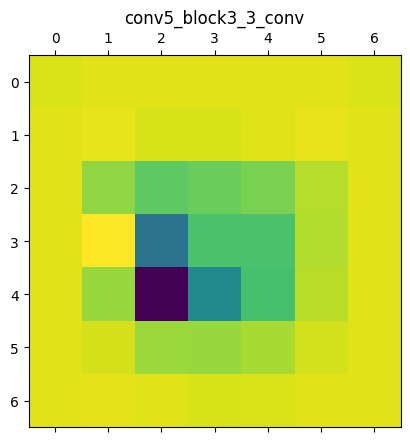

conv5_block3_3_bn (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

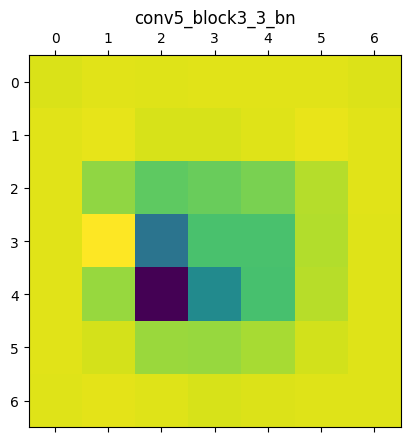

conv5_block3_add (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

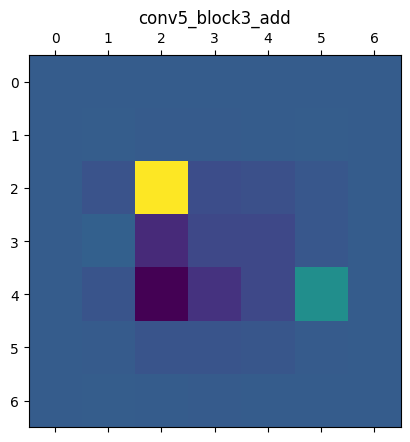

conv5_block3_out (1, 7, 7, 2048)


<Figure size 640x480 with 0 Axes>

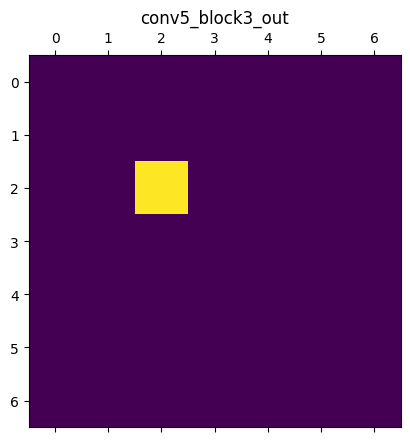

global_average_pooling2d (1, 2048)
dense (1, 256)
dense_1 (1, 58)


In [32]:
import tensorflow as tf


def get_activations(model, input_data):
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(input_data)
    return activations
sample_input = X_train_resized[:1]  # assuming X_train_resized is your input data
activations = get_activations(resnet_model, sample_input)


for layer_name, activation in zip(resnet_model.layers, activations):
    print(layer_name.name, activation.shape)
    if len(activation.shape) == 4:
        plt.figure()
        plt.matshow(activation[0, :, :, 0], cmap='viridis')
        plt.title(layer_name.name)
        plt.show()

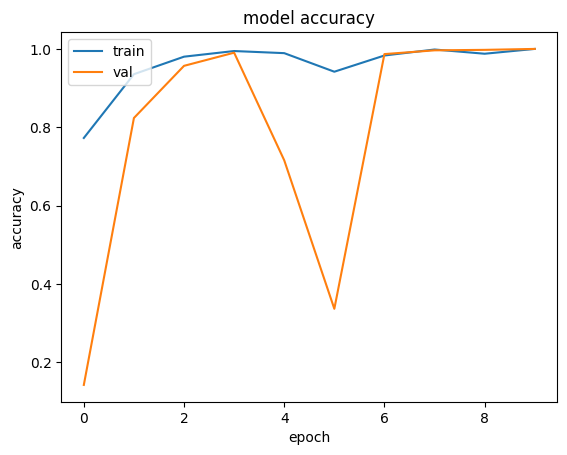

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

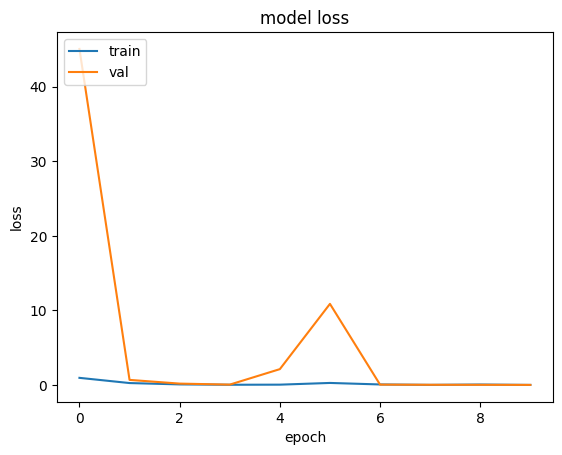

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

27/27 [==============================] - 161s 6s/step


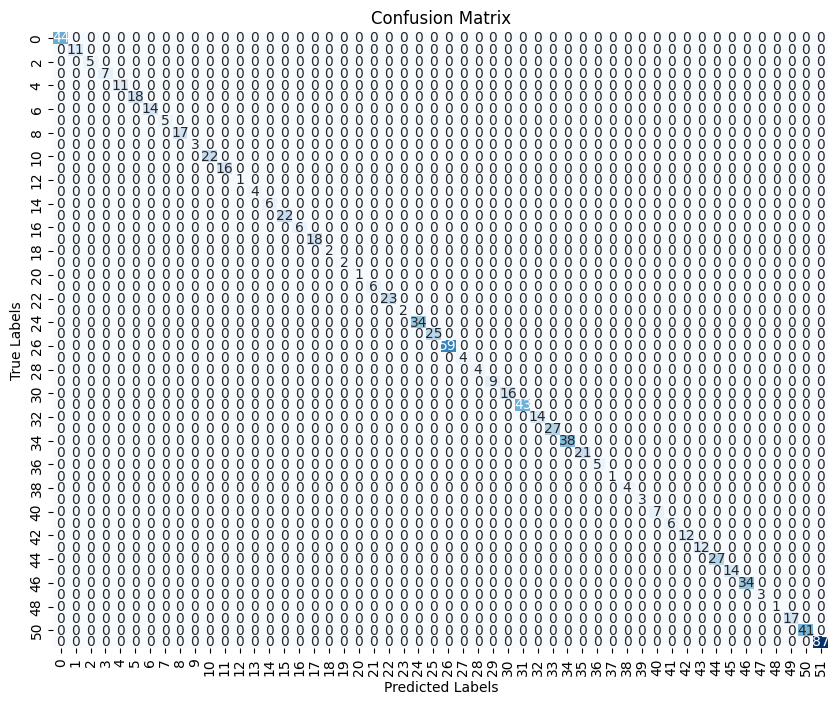

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        17
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00        22
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00        22
          17       1.00      1.00      1.00         6
          18       1.00    

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = resnet_model.predict(X_test_resized)

y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test_encoded, y_pred_labels))